#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from numpy.random import choice
from numpy.linalg import norm

from math import factorial

from itertools import permutations

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import umap

from tqdm import tqdm
import os

In [2]:
from numpy.linalg import svd, eigvals
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, homogeneity_completeness_v_measure, confusion_matrix, ConfusionMatrixDisplay

In [4]:
from skdim.id import *

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
plt.style.use('seaborn-whitegrid')
# plt.style.use('default')

In [7]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [8]:
from generate_data import generate_permuted_sequence, makeTensorLoaders

#### Test for CUDA

In [9]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


### Model training

#### Number of runs

In [10]:
nRuns = 5

#### Generate data for nRuns

In [11]:
nTot = 1000

nStates_reg = 3 ## Number of possible unique states (expected stimuli)
nStates_surp = factorial(nStates_reg) ## Number of possible unique states (surprise elements)
dim = 64 ## Dimensionality of the samples

fracTrain = 0.8
fracTest = np.round(1-fracTrain,2)

nTrain = int(nTot*fracTrain)
nTest = nTot - nTrain

fracSurprise_train = 0.00
fracSurprise_test = 0.5

lenSeq = nStates_reg + 1
nRepeats = 2

nStates_tot = nStates_reg + nStates_surp

In [12]:
def templateMaker(nStates_reg, nStates_surp, dim):
    ## Generate template representations (for expected elements)
    template_reg = np.zeros((nStates_reg, dim))
    for ii in range(nStates_reg):
        template_reg[ii] = choice(2, dim, p=[0.75, 0.25])## p=[Pr(0),Pr(1)]

    ## Generate template representations (for surprise elements)
    template_surp = np.zeros((nStates_surp, dim))
    for ii in range(nStates_surp):
        template_surp[ii] = choice(2, dim, p=[0.75, 0.25])## p=[Pr(0),Pr(1)]

    template = np.vstack((template_reg, template_surp))
    return template

In [13]:
template = {}
for cntr in range(nRuns):
    template[cntr] = templateMaker(nStates_reg,nStates_surp,dim)

In [14]:
def allStatesRepsTemplate(reps,yReps,allStates):
    numSamps, numSteps, dim = reps.shape
    seqIDs = np.unique(allStates[:,-1])
    numUniqueSequences = len(seqIDs)
    sequencesAll = np.zeros((numUniqueSequences,numSteps,dim))
    ySequencesAll = np.zeros((numUniqueSequences,numSteps,dim))
    for ii, seqID in enumerate(seqIDs):
        idx = np.min(np.where(allStates[:,-1]==seqID)[0])
        sequencesAll[ii] = reps[idx]
        ySequencesAll[ii] = yReps[idx] 
    return sequencesAll, ySequencesAll

In [15]:
repsTrain = {}
yRepsTrain = {}
eTrain = {}
pTrain = {}
surpTrain = {}
allStatesTrain = {}

In [16]:
repsTest = {}
yRepsTest = {}
eTest = {}
pTest = {}
surpTest = {}
allStatesTest = {}

In [17]:
for cntr in range(nRuns):
    (repsTrain[cntr],yRepsTrain[cntr],eTrain[cntr],pTrain[cntr],surpTrain[cntr]),\
    __,\
    (allStatesTrain[cntr],__),\
    template[cntr] = generate_permuted_sequence(int(nTot*fracTrain),1.,nStates_reg,dim,lenSeq,
                                          fracSurprise_train,template=template[cntr])

In [18]:
for cntr in range(nRuns):
    (repsTest[cntr],yRepsTest[cntr],eTest[cntr],pTest[cntr],surpTest[cntr]),\
    __,\
    (allStatesTest[cntr],__),\
    template[cntr] = generate_permuted_sequence(int(nTot*fracTest),1.,nStates_reg,dim,lenSeq,
                                          fracSurprise_test,template=template[cntr])

In [19]:
cleanSequences = {}
yCleanSequences = {}

surpSequences = {}
ySurpSequences = {}

In [20]:
surpRepsTest = {}
ySurpsTest = {}
surpAllStatesTest = {}

In [21]:
for cntr in range(nRuns):
    cleanSequences[cntr], yCleanSequences[cntr] = allStatesRepsTemplate(repsTrain[cntr],yRepsTrain[cntr],
                                                                        allStatesTrain[cntr])

In [22]:
for cntr in range(nRuns):
    surpRepsTest[cntr] = repsTest[cntr][np.where(surpTest[cntr]==1)]
    ySurpsTest[cntr] = yRepsTest[cntr][np.where(surpTest[cntr]==1)]

    surpAllStatesTest[cntr] = allStatesTest[cntr][np.where(surpTest[cntr]==1)]

    surpSequences[cntr], ySurpSequences[cntr] = allStatesRepsTemplate(surpRepsTest[cntr],ySurpsTest[cntr],
                                                                      surpAllStatesTest[cntr])

#### Create directories to save data and representations

In [23]:
pp = ## specify path

In [24]:
npp = {}
pp_npy = {}
pp_pts = {}

In [25]:
for cntr in range(nRuns):
    
    npp[cntr] = 'abcd-regular-no-td-all-combo-'+str(cntr)+'/'
    pp_npy[cntr] = pp+npp[cntr]+'npys-'+str(cntr)+'/'
    pp_pts[cntr] = pp+npp[cntr]+'pts-'+str(cntr)+'/'

## uncomment the following lines to create the folders. comment out if already created
    
#     os.mkdir(os.path.join(pp,npp[cntr]))
#     os.mkdir(os.path.join(pp,npp[cntr],pp_npy[cntr]))
#     os.mkdir(os.path.join(pp,npp[cntr],pp_pts[cntr]))

#     os.mkdir(os.path.join(pp,npp[cntr],pp_npy[cntr],'Dataset/'))

#### Save template and dataset

In [26]:
seeds = np.random.randint(1000, size=nRuns)
np.save(pp_npy[cntr]+'seeds',seeds)

In [27]:
for cntr in range(nRuns):
    ## Template
    np.save(pp_npy[cntr]+'Dataset/template',template[cntr])

    ## Train Data
    np.save(pp_npy[cntr]+'Dataset/repsTrain',repsTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/yRepsTrain',yRepsTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/eTrain',eTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/pTrain',pTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/surpTrain',surpTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/allStatesTrain',allStatesTrain[cntr])

    ## Test Data
    np.save(pp_npy[cntr]+'Dataset/repsTest',repsTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/yRepsTest',yRepsTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/eTest',eTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/pTest',pTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/surpTest',surpTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/allStatesTest',allStatesTest[cntr])

    np.save(pp_npy[cntr]+'Dataset/cleanSequences',cleanSequences[cntr])
    np.save(pp_npy[cntr]+'Dataset/surpSequences',surpSequences[cntr])

    np.save(pp_npy[cntr]+'Dataset/yCleanSequences',yCleanSequences[cntr])
    np.save(pp_npy[cntr]+'Dataset/ySurpSequences',ySurpSequences[cntr])

#### Convert data to tensors, create train and test loaders

In [28]:
batch_size = 100 ##100

In [29]:
pos_seq_idx = np.array([0,0,1,1,2,2])

In [30]:
train_loader = {}
test_loader = {}

In [31]:
for cntr in range(nRuns):
    train_loader[cntr] = makeTensorLoaders((repsTrain[cntr],yRepsTrain[cntr],eTrain[cntr],pTrain[cntr],surpTrain[cntr]),
                                           batch_size,shuffle=True)
    test_loader[cntr] = makeTensorLoaders((repsTest[cntr],yRepsTest[cntr],eTest[cntr],pTest[cntr],surpTest[cntr]),
                                          batch_size,shuffle=False)

#### Load architecture, models, optimizers

In [32]:
n_latent = 16 ## make sure it is the same in the architecture file as well
pop_list = [2,5,4] ## make sure it is the same in the architecture file as well

In [33]:
from architecture_no_td_all_combo import microcircuit

In [34]:
model = {}
optimizer = {}

In [35]:
#specify loss function
reconLoss = nn.MSELoss()

#optimizer learning rate
eta = 0.001

In [36]:
for cntr in range(nRuns):
    model[cntr] = microcircuit(hidden_dim=n_latent,pop_list=pop_list,bsize=batch_size,manual_seed=seeds[cntr])
    model[cntr].to(device)
    optimizer[cntr] = torch.optim.Adam(model[cntr].parameters(), lr=eta)

#### Train and collect activations

In [37]:
for data, f_target, lastEvent, surprisePosition, surpriseBinary in train_loader[0]:
    if train_on_gpu:
        data, f_target = data.float().cuda(), f_target.float().cuda()
    else: data, f_target = data.float(), f_target.float()

In [38]:
output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[0](data)

In [39]:
nSteps = data.shape[1]

In [40]:
n_epochs = 50 ## number of epochs
div = n_epochs//n_epochs ## try ensuring that number used to divide by is a factor of n_epochs

In [41]:
train_losses = {}
test_losses = {}

train_expected_losses = {}
train_surprise_losses = {}

test_expected_losses = {}
test_surprise_losses = {}

MSE_mat_full_test = {}

In [42]:
for cntr in tqdm(range(nRuns)):
    
    train_losses[cntr] = np.zeros(n_epochs+1)
    test_losses[cntr] = np.zeros(n_epochs+1)

    train_loss_min = np.Inf
    best_epoch = 0

    train_expected_losses[cntr] = np.zeros(n_epochs+1)
    train_surprise_losses[cntr] = np.zeros(n_epochs+1)

    test_expected_losses[cntr] = np.zeros((n_epochs+1))
    test_surprise_losses[cntr] = np.zeros((n_epochs+1))

    MSE_mat_full_test[cntr] = np.zeros((n_epochs+1,nTest,nSteps)) ##Note -2 change

    for epoch in (range(1,n_epochs+1)):

        train_loss = 0.0

        train_loss = 0.0
        train_expected_loss = 0.0
        train_surprise_loss = 0.0

        test_expected_loss = 0.0
        test_surprise_loss = 0.0
        
        test_loss = 0.0

        cnt = 0
        
        ## Save model without training
        if epoch == 1:
            
            model[cntr].eval()
            torch.save(model[cntr].state_dict(), pp_pts[cntr]+'predRNN_epoch_0.pt') ## Save model before any training
            
            ## Losses at 0th epoch
            for data, f_target, lastEvent, surprisePosition, surpriseBinary in train_loader[cntr]:
                if train_on_gpu:
                    data, f_target = data.float().cuda(), f_target.float().cuda()
                else:
                    data, f_target = data.float(), f_target.float()

                ##define all-sequence targets
#                 target = torch.cat((data[:,2:,:],f_target.repeat(1,2,1)),dim=1)
                target = f_target

                optimizer[cntr].zero_grad() #clears older gradients
                output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[cntr](data) #forward pass
                loss = reconLoss(output_pred[:,2:],target[:,2:]) #calculate the loss for the batch
                train_loss += loss.item()*data.size(0) #update training loss

                err = torch.linalg.norm((output_pred[:,2:]-target[:,2:]),dim=2)
                errSq = err**2
                MSE_mat_samples_seq = errSq/np.prod(errSq.shape)
                MSE_samples = torch.mean(MSE_mat_samples_seq,1)
                train_expected_loss += torch.mean(MSE_samples[torch.where(surpriseBinary==0)[0]])
                if (len(torch.where(surpriseBinary==1)[0])>0):
                    train_surprise_loss += torch.mean(MSE_samples[torch.where(surpriseBinary==1)[0]])
                    
            ## calculate average loss
            train_loss = train_loss/len(train_loader[cntr].dataset)
            
            ## Training loss at initialization
            train_losses[cntr][0] = train_loss
            train_expected_losses[cntr][0] = train_expected_loss
            train_surprise_losses[cntr][0] = train_surprise_loss
            
            ## Test losses at initialization
            for data_test, f_target_test, le_test, sp_test, sb_test in test_loader[cntr]:
                if train_on_gpu:
                    data_test, f_target_test = data_test.float().cuda(), f_target_test.float().cuda()
                else:
                    data_test, f_target_test = data_test.float(), f_target_test.float()

                ## outputs
                output_pred_test, RNN_outputs_test, feedbackDiffs_test, projInterArea_test = model[cntr](data_test)

                ##define all-sequence targets
    #             target_test = torch.cat((data_test[:,2:,:],f_target_test.repeat(1,2,1)),dim=1)
                target_test = f_target_test

                # calculate the batch loss
                loss_test = reconLoss(output_pred_test[:,2:],target_test[:,2:])

                err_test = torch.linalg.norm((output_pred_test[:,2:]-target_test[:,2:]),dim=2)
                errSq_test = err_test**2
                MSE_mat_samples_seq_test = errSq_test/np.prod(errSq_test.shape)
                MSE_samples_test = torch.mean(MSE_mat_samples_seq_test,1)
                test_expected_loss += torch.mean(MSE_samples_test[torch.where(sb_test==0)[0]])
                test_surprise_loss += torch.mean(MSE_samples_test[torch.where(sb_test==1)[0]])

                # update test loss 
                test_loss += loss_test.item()*data_test.size(0)

            # average test loss
            test_loss = test_loss/len(test_loader[cntr].dataset)
#             print('Test Loss: {:.6f}\n'.format(test_loss))

            test_losses[cntr][0] = test_loss

            test_expected_losses[cntr][0] = test_expected_loss
            test_surprise_losses[cntr][0] = test_surprise_loss
                
            

        #train model
        model[cntr].train()
        for data, f_target, lastEvent, surprisePosition, surpriseBinary in train_loader[cntr]:
            if train_on_gpu:
                data, f_target = data.float().cuda(), f_target.float().cuda()
            else:
                data, f_target = data.float(), f_target.float()

            ##define all-sequence targets
    #         target = torch.cat((data[:,2:,:],f_target.repeat(1,2,1)),dim=1)
            target = f_target

            optimizer[cntr].zero_grad() #clears older gradients
            output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[cntr](data) #forward pass
            loss = reconLoss(output_pred[:,2:],target[:,2:]) #calculate the loss for the batch
            loss.backward() #backprop
            optimizer[cntr].step() #update parameters in direction of the -ve gradient
            train_loss += loss.item()*data.size(0) #update training loss

            err = torch.linalg.norm((output_pred[:,2:]-target[:,2:]),dim=2)
            errSq = err**2
            MSE_mat_samples_seq = errSq/np.prod(errSq.shape)
            MSE_samples = torch.mean(MSE_mat_samples_seq,1)
            train_expected_loss += torch.mean(MSE_samples[torch.where(surpriseBinary==0)[0]])
            if (len(torch.where(surpriseBinary==1)[0])>0):
                train_surprise_loss += torch.mean(MSE_samples[torch.where(surpriseBinary==1)[0]])

        #calculate average loss
        train_loss = train_loss/len(train_loader[cntr].dataset)

        #training/validation stats
    #     print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
        train_losses[cntr][epoch] = train_loss

        train_expected_losses[cntr][epoch] = train_expected_loss
        train_surprise_losses[cntr][epoch] = train_surprise_loss

        #save model if the training loss decreased
        if train_loss <= train_loss_min:
            print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
            torch.save(model[cntr].state_dict(),pp_pts[cntr]+'predRNN.pt')
            train_loss_min = train_loss
            best_epoch = epoch

        if epoch%div == 0:
            torch.save(model[cntr].state_dict(), pp_pts[cntr]+'predRNN_epoch_'+str(epoch)+'.pt')

            activations_hidden_L23_np = np.zeros((nTest,nSteps,pop_list[1]*n_latent))
            activations_hidden_L4_np = np.zeros((nTest,nSteps,pop_list[0]*n_latent))
            activations_hidden_L56_np = np.zeros((nTest,nSteps,pop_list[2]*n_latent))

            activations_hidden_H23_np = np.zeros((nTest,nSteps,pop_list[1]*n_latent))
            activations_hidden_H4_np = np.zeros((nTest,nSteps,pop_list[0]*n_latent))
            activations_hidden_H56_np = np.zeros((nTest,nSteps,pop_list[2]*n_latent))

            activations_FF_np = np.zeros((nTest,nSteps,pop_list[0]*n_latent))
            activations_FBa_np = np.zeros((nTest,nSteps,pop_list[1]*n_latent))
            activations_FBb_np = np.zeros((nTest,nSteps,pop_list[2]*n_latent))

            activations_out_np = np.zeros((nTest,nSteps,dim))

            model[cntr].eval()
            for data_test, f_target_test, le_test, sp_test, sb_test in test_loader[cntr]:
                if train_on_gpu:
                    data_test, f_target_test = data_test.float().cuda(), f_target_test.float().cuda()
                else:
                    data_test, f_target_test = data_test.float(), f_target_test.float()

                ## outputs
                output_pred_test, RNN_outputs_test, feedbackDiffs_test, projInterArea_test = model[cntr](data_test)

                ##define all-sequence targets
    #             target_test = torch.cat((data_test[:,2:,:],f_target_test.repeat(1,2,1)),dim=1)
                target_test = f_target_test

                # calculate the batch loss
                loss_test = reconLoss(output_pred_test[:,2:],target_test[:,2:])

                err_test = torch.linalg.norm((output_pred_test[:,2:]-target_test[:,2:]),dim=2)
                errSq_test = err_test**2
                MSE_mat_samples_seq_test = errSq_test/np.prod(errSq_test.shape)
                MSE_samples_test = torch.mean(MSE_mat_samples_seq_test,1)
                test_expected_loss += torch.mean(MSE_samples_test[torch.where(sb_test==0)[0]])
                test_surprise_loss += torch.mean(MSE_samples_test[torch.where(sb_test==1)[0]])

                # update test loss 
                test_loss += loss_test.item()*data_test.size(0)

                act_hidden_L23 = np.squeeze(RNN_outputs_test[0].detach().cpu().numpy())
                act_hidden_L4 = np.squeeze(RNN_outputs_test[1].detach().cpu().numpy())
                act_hidden_L56 = np.squeeze(RNN_outputs_test[2].detach().cpu().numpy())

                act_hidden_H23 = np.squeeze(RNN_outputs_test[3].detach().cpu().numpy())
                act_hidden_H4 = np.squeeze(RNN_outputs_test[4].detach().cpu().numpy())
                act_hidden_H56 = np.squeeze(RNN_outputs_test[5].detach().cpu().numpy())

                act_FF = np.squeeze(projInterArea_test[0].detach().cpu().numpy())
                act_FBa = np.squeeze(projInterArea_test[1].detach().cpu().numpy()) 
                act_FBb = np.squeeze(projInterArea_test[2].detach().cpu().numpy())

                output_pred_test = np.squeeze(output_pred_test.detach().cpu().numpy())

                for i in range(batch_size):
                    if i < len(data_test):
                        label = target_test.data[i]

                        activations_hidden_L23_np[cnt] = act_hidden_L23[i]
                        activations_hidden_L4_np[cnt] = act_hidden_L4[i]
                        activations_hidden_L56_np[cnt] = act_hidden_L56[i]

                        activations_hidden_H23_np[cnt] = act_hidden_H23[i]
                        activations_hidden_H4_np[cnt] = act_hidden_H4[i]
                        activations_hidden_H56_np[cnt] = act_hidden_H56[i]

                        activations_FF_np[cnt] = act_FF[i]
                        activations_FBa_np[cnt] = act_FBa[i]
                        activations_FBb_np[cnt] = act_FBb[i]

                        activations_out_np[cnt] = output_pred_test[i]

                        MSE_mat_full_test[cntr][epoch-1,cnt,2:] = MSE_mat_samples_seq_test[i,].detach().cpu().numpy()

                        cnt += 1

#             np.save(pp_npy[cntr]+'predRNN_hidden_L23_epoch_'+str(epoch), activations_hidden_L23_np)
#             np.save(pp_npy[cntr]+'predRNN_hidden_L4_epoch_'+str(epoch), activations_hidden_L4_np)
#             np.save(pp_npy[cntr]+'predRNN_hidden_L56_epoch_'+str(epoch), activations_hidden_L56_np)

#             np.save(pp_npy[cntr]+'predRNN_hidden_H23_epoch_'+str(epoch), activations_hidden_H23_np)
#             np.save(pp_npy[cntr]+'predRNN_hidden_H4_epoch_'+str(epoch), activations_hidden_H4_np)
#             np.save(pp_npy[cntr]+'predRNN_hidden_H56_epoch_'+str(epoch), activations_hidden_H56_np)

#             np.save(pp_npy[cntr]+'predRNN_hidden_FF_epoch_'+str(epoch),activations_FF_np)
#             np.save(pp_npy[cntr]+'predRNN_hidden_FBa_epoch_'+str(epoch),activations_FBa_np)
#             np.save(pp_npy[cntr]+'predRNN_hidden_FBb_epoch_'+str(epoch),activations_FBb_np)

#             np.save(pp_npy[cntr]+'predRNN_out_epoch_'+str(epoch), activations_out_np)

            # average test loss
            test_loss = test_loss/len(test_loader[cntr].dataset)
#             print('Test Loss: {:.6f}\n'.format(test_loss))

            test_losses[cntr][epoch] = test_loss

            test_expected_losses[cntr][epoch] = test_expected_loss
            test_surprise_losses[cntr][epoch] = test_surprise_loss
            
    print('----------------------------------------------------')
            
    outF = open(pp+npp[cntr]+"training-details.txt", "w")
    outF.write('# epochs = ' + str(n_epochs))
    outF.write('\n')
    outF.write('Best epoch = '+str(best_epoch))
    outF.write('\n')
    outF.write('Minimum training loss = ' + str(train_loss_min))
    outF.write('\n')
    outF.write('Total number of samples = ' + str(nTot))
    outF.write('\n')
    outF.write('Number of training samples = ' + str(nTrain))
    outF.write('\n')
    outF.write('Number of testing samples = ' + str(nTest))
    outF.write('\n')
    outF.write('Number of states (regular) = ' + str(nStates_reg))
    outF.write('\n')
    outF.write('Number of states (surprise) = ' + str(nStates_surp))
    outF.write('\n')
    outF.write('Fraction surprise (train) = ' + str(fracSurprise_train))
    outF.write('\n')
    outF.write('Fraction surprise (test) = ' + str(fracSurprise_test))
    outF.write('\n')
    outF.write('Dimensionality of representations = ' + str(dim))
    outF.write('\n')
    outF.write('Length of sequences = ' + str(lenSeq))
    outF.write('\n')
    outF.close()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1, Train Loss Decreased!! (inf-->0.241485)
Epoch: 2, Train Loss Decreased!! (0.241485-->0.187980)
Epoch: 3, Train Loss Decreased!! (0.187980-->0.165267)
Epoch: 4, Train Loss Decreased!! (0.165267-->0.157255)
Epoch: 5, Train Loss Decreased!! (0.157255-->0.151614)
Epoch: 6, Train Loss Decreased!! (0.151614-->0.149194)
Epoch: 7, Train Loss Decreased!! (0.149194-->0.148264)
Epoch: 8, Train Loss Decreased!! (0.148264-->0.147583)
Epoch: 9, Train Loss Decreased!! (0.147583-->0.147282)
Epoch: 10, Train Loss Decreased!! (0.147282-->0.147149)
Epoch: 11, Train Loss Decreased!! (0.147149-->0.146891)
Epoch: 12, Train Loss Decreased!! (0.146891-->0.146398)
Epoch: 13, Train Loss Decreased!! (0.146398-->0.145327)
Epoch: 14, Train Loss Decreased!! (0.145327-->0.142877)
Epoch: 15, Train Loss Decreased!! (0.142877-->0.138479)
Epoch: 16, Train Loss Decreased!! (0.138479-->0.133819)
Epoch: 17, Train Loss Decreased!! (0.133819-->0.131190)
Epoch: 18, Train Loss Decreased!! (0.131190-->0.128157)
Epoch:

 20%|██        | 1/5 [02:22<09:31, 142.81s/it]

Epoch: 50, Train Loss Decreased!! (0.081069-->0.080826)
----------------------------------------------------
Epoch: 1, Train Loss Decreased!! (inf-->0.228655)
Epoch: 2, Train Loss Decreased!! (0.228655-->0.178741)
Epoch: 3, Train Loss Decreased!! (0.178741-->0.153374)
Epoch: 4, Train Loss Decreased!! (0.153374-->0.145943)
Epoch: 5, Train Loss Decreased!! (0.145943-->0.142083)
Epoch: 6, Train Loss Decreased!! (0.142083-->0.140758)
Epoch: 7, Train Loss Decreased!! (0.140758-->0.139743)
Epoch: 8, Train Loss Decreased!! (0.139743-->0.139150)
Epoch: 9, Train Loss Decreased!! (0.139150-->0.138796)
Epoch: 10, Train Loss Decreased!! (0.138796-->0.138278)
Epoch: 11, Train Loss Decreased!! (0.138278-->0.137451)
Epoch: 12, Train Loss Decreased!! (0.137451-->0.135738)
Epoch: 13, Train Loss Decreased!! (0.135738-->0.132064)
Epoch: 14, Train Loss Decreased!! (0.132064-->0.127108)
Epoch: 15, Train Loss Decreased!! (0.127108-->0.124507)
Epoch: 16, Train Loss Decreased!! (0.124507-->0.122098)
Epoch: 17

 40%|████      | 2/5 [04:29<06:40, 133.56s/it]

----------------------------------------------------
Epoch: 1, Train Loss Decreased!! (inf-->0.243430)
Epoch: 2, Train Loss Decreased!! (0.243430-->0.189968)
Epoch: 3, Train Loss Decreased!! (0.189968-->0.163322)
Epoch: 4, Train Loss Decreased!! (0.163322-->0.153252)
Epoch: 5, Train Loss Decreased!! (0.153252-->0.148636)
Epoch: 6, Train Loss Decreased!! (0.148636-->0.146114)
Epoch: 7, Train Loss Decreased!! (0.146114-->0.145010)
Epoch: 8, Train Loss Decreased!! (0.145010-->0.144218)
Epoch: 9, Train Loss Decreased!! (0.144218-->0.143569)
Epoch: 10, Train Loss Decreased!! (0.143569-->0.142562)
Epoch: 11, Train Loss Decreased!! (0.142562-->0.140904)
Epoch: 12, Train Loss Decreased!! (0.140904-->0.138757)
Epoch: 13, Train Loss Decreased!! (0.138757-->0.135871)
Epoch: 14, Train Loss Decreased!! (0.135871-->0.132354)
Epoch: 15, Train Loss Decreased!! (0.132354-->0.129183)
Epoch: 16, Train Loss Decreased!! (0.129183-->0.126323)
Epoch: 17, Train Loss Decreased!! (0.126323-->0.123437)
Epoch: 18

 60%|██████    | 3/5 [06:43<04:27, 133.62s/it]

----------------------------------------------------
Epoch: 1, Train Loss Decreased!! (inf-->0.241951)
Epoch: 2, Train Loss Decreased!! (0.241951-->0.184998)
Epoch: 3, Train Loss Decreased!! (0.184998-->0.162672)
Epoch: 4, Train Loss Decreased!! (0.162672-->0.150844)
Epoch: 5, Train Loss Decreased!! (0.150844-->0.139781)
Epoch: 6, Train Loss Decreased!! (0.139781-->0.135357)
Epoch: 7, Train Loss Decreased!! (0.135357-->0.133883)
Epoch: 8, Train Loss Decreased!! (0.133883-->0.133223)
Epoch: 9, Train Loss Decreased!! (0.133223-->0.132901)
Epoch: 10, Train Loss Decreased!! (0.132901-->0.132744)
Epoch: 11, Train Loss Decreased!! (0.132744-->0.132458)
Epoch: 12, Train Loss Decreased!! (0.132458-->0.132435)
Epoch: 13, Train Loss Decreased!! (0.132435-->0.132010)
Epoch: 14, Train Loss Decreased!! (0.132010-->0.131621)
Epoch: 15, Train Loss Decreased!! (0.131621-->0.130765)
Epoch: 16, Train Loss Decreased!! (0.130765-->0.128997)
Epoch: 17, Train Loss Decreased!! (0.128997-->0.125538)
Epoch: 18

 80%|████████  | 4/5 [09:02<02:15, 135.54s/it]

Epoch: 1, Train Loss Decreased!! (inf-->0.224195)
Epoch: 2, Train Loss Decreased!! (0.224195-->0.176411)
Epoch: 3, Train Loss Decreased!! (0.176411-->0.152741)
Epoch: 4, Train Loss Decreased!! (0.152741-->0.144966)
Epoch: 5, Train Loss Decreased!! (0.144966-->0.140600)
Epoch: 6, Train Loss Decreased!! (0.140600-->0.138299)
Epoch: 7, Train Loss Decreased!! (0.138299-->0.137518)
Epoch: 8, Train Loss Decreased!! (0.137518-->0.136332)
Epoch: 9, Train Loss Decreased!! (0.136332-->0.134744)
Epoch: 10, Train Loss Decreased!! (0.134744-->0.132440)
Epoch: 11, Train Loss Decreased!! (0.132440-->0.129078)
Epoch: 12, Train Loss Decreased!! (0.129078-->0.124923)
Epoch: 13, Train Loss Decreased!! (0.124923-->0.121589)
Epoch: 14, Train Loss Decreased!! (0.121589-->0.119937)
Epoch: 15, Train Loss Decreased!! (0.119937-->0.118765)
Epoch: 16, Train Loss Decreased!! (0.118765-->0.117620)
Epoch: 17, Train Loss Decreased!! (0.117620-->0.115929)
Epoch: 18, Train Loss Decreased!! (0.115929-->0.113093)
Epoch:

100%|██████████| 5/5 [11:11<00:00, 134.34s/it]

----------------------------------------------------


In [43]:
# kk = 0
# f = plt.figure(figsize=(10,10))

# plt.subplot(2,2,1)
# plt.plot((train_losses[kk]),'-x')
# plt.title('Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('MSE')

# plt.subplot(2,2,2)
# plt.plot((train_expected_losses[kk]),'-x',label='Expected')
# plt.plot((train_surprise_losses[kk]),'-o',label='Surprise')
# plt.title('Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('MSE')
# plt.legend()

# plt.subplot(2,2,3)
# plt.plot((test_losses[kk]),'-x')
# plt.title('Test Loss')
# plt.xlabel('Epochs')
# plt.ylabel('MSE')

# plt.subplot(2,2,4)
# plt.plot((test_expected_losses[kk]),'-x',label='Expected')
# plt.plot((test_surprise_losses[kk]),'-o',label='Surprise')
# plt.title('Test Loss')
# plt.xlabel('Epochs')
# plt.ylabel('MSE')
# plt.legend()

# plt.show()

In [44]:
train_losses_mat = np.zeros((nRuns,n_epochs+1))
test_losses_mat = np.zeros((nRuns,n_epochs+1))

train_expected_losses_mat = np.zeros((nRuns,n_epochs+1))
train_surprise_losses_mat = np.zeros((nRuns,n_epochs+1))

test_expected_losses_mat = np.zeros((nRuns,n_epochs+1))
test_surprise_losses_mat = np.zeros((nRuns,n_epochs+1))

In [45]:
for cntr in range(nRuns):
    train_losses_mat[cntr] = train_losses[cntr]
    test_losses_mat[cntr] = test_losses[cntr]
    
    train_expected_losses_mat[cntr] = train_expected_losses[cntr]
    train_surprise_losses_mat[cntr] = train_surprise_losses[cntr]
    
    test_expected_losses_mat[cntr] = test_expected_losses[cntr]
    test_surprise_losses_mat[cntr] = test_surprise_losses[cntr]

In [46]:
train_losses_mean = np.mean(train_losses_mat,axis=0)
test_losses_mean = np.mean(test_losses_mat,axis=0)

train_expected_losses_mean = np.mean(train_expected_losses_mat,axis=0)
train_surprise_losses_mean = np.mean(train_surprise_losses_mat,axis=0)

test_expected_losses_mean = np.mean(test_expected_losses_mat,axis=0)
test_surprise_losses_mean = np.mean(test_surprise_losses_mat,axis=0)

In [47]:
train_losses_std = np.std(train_losses_mat,axis=0)
test_losses_std = np.std(test_losses_mat,axis=0)

train_expected_losses_std = np.std(train_expected_losses_mat,axis=0)
train_surprise_losses_std = np.std(train_surprise_losses_mat,axis=0)

test_expected_losses_std = np.std(test_expected_losses_mat,axis=0)
test_surprise_losses_std = np.std(test_surprise_losses_mat,axis=0)

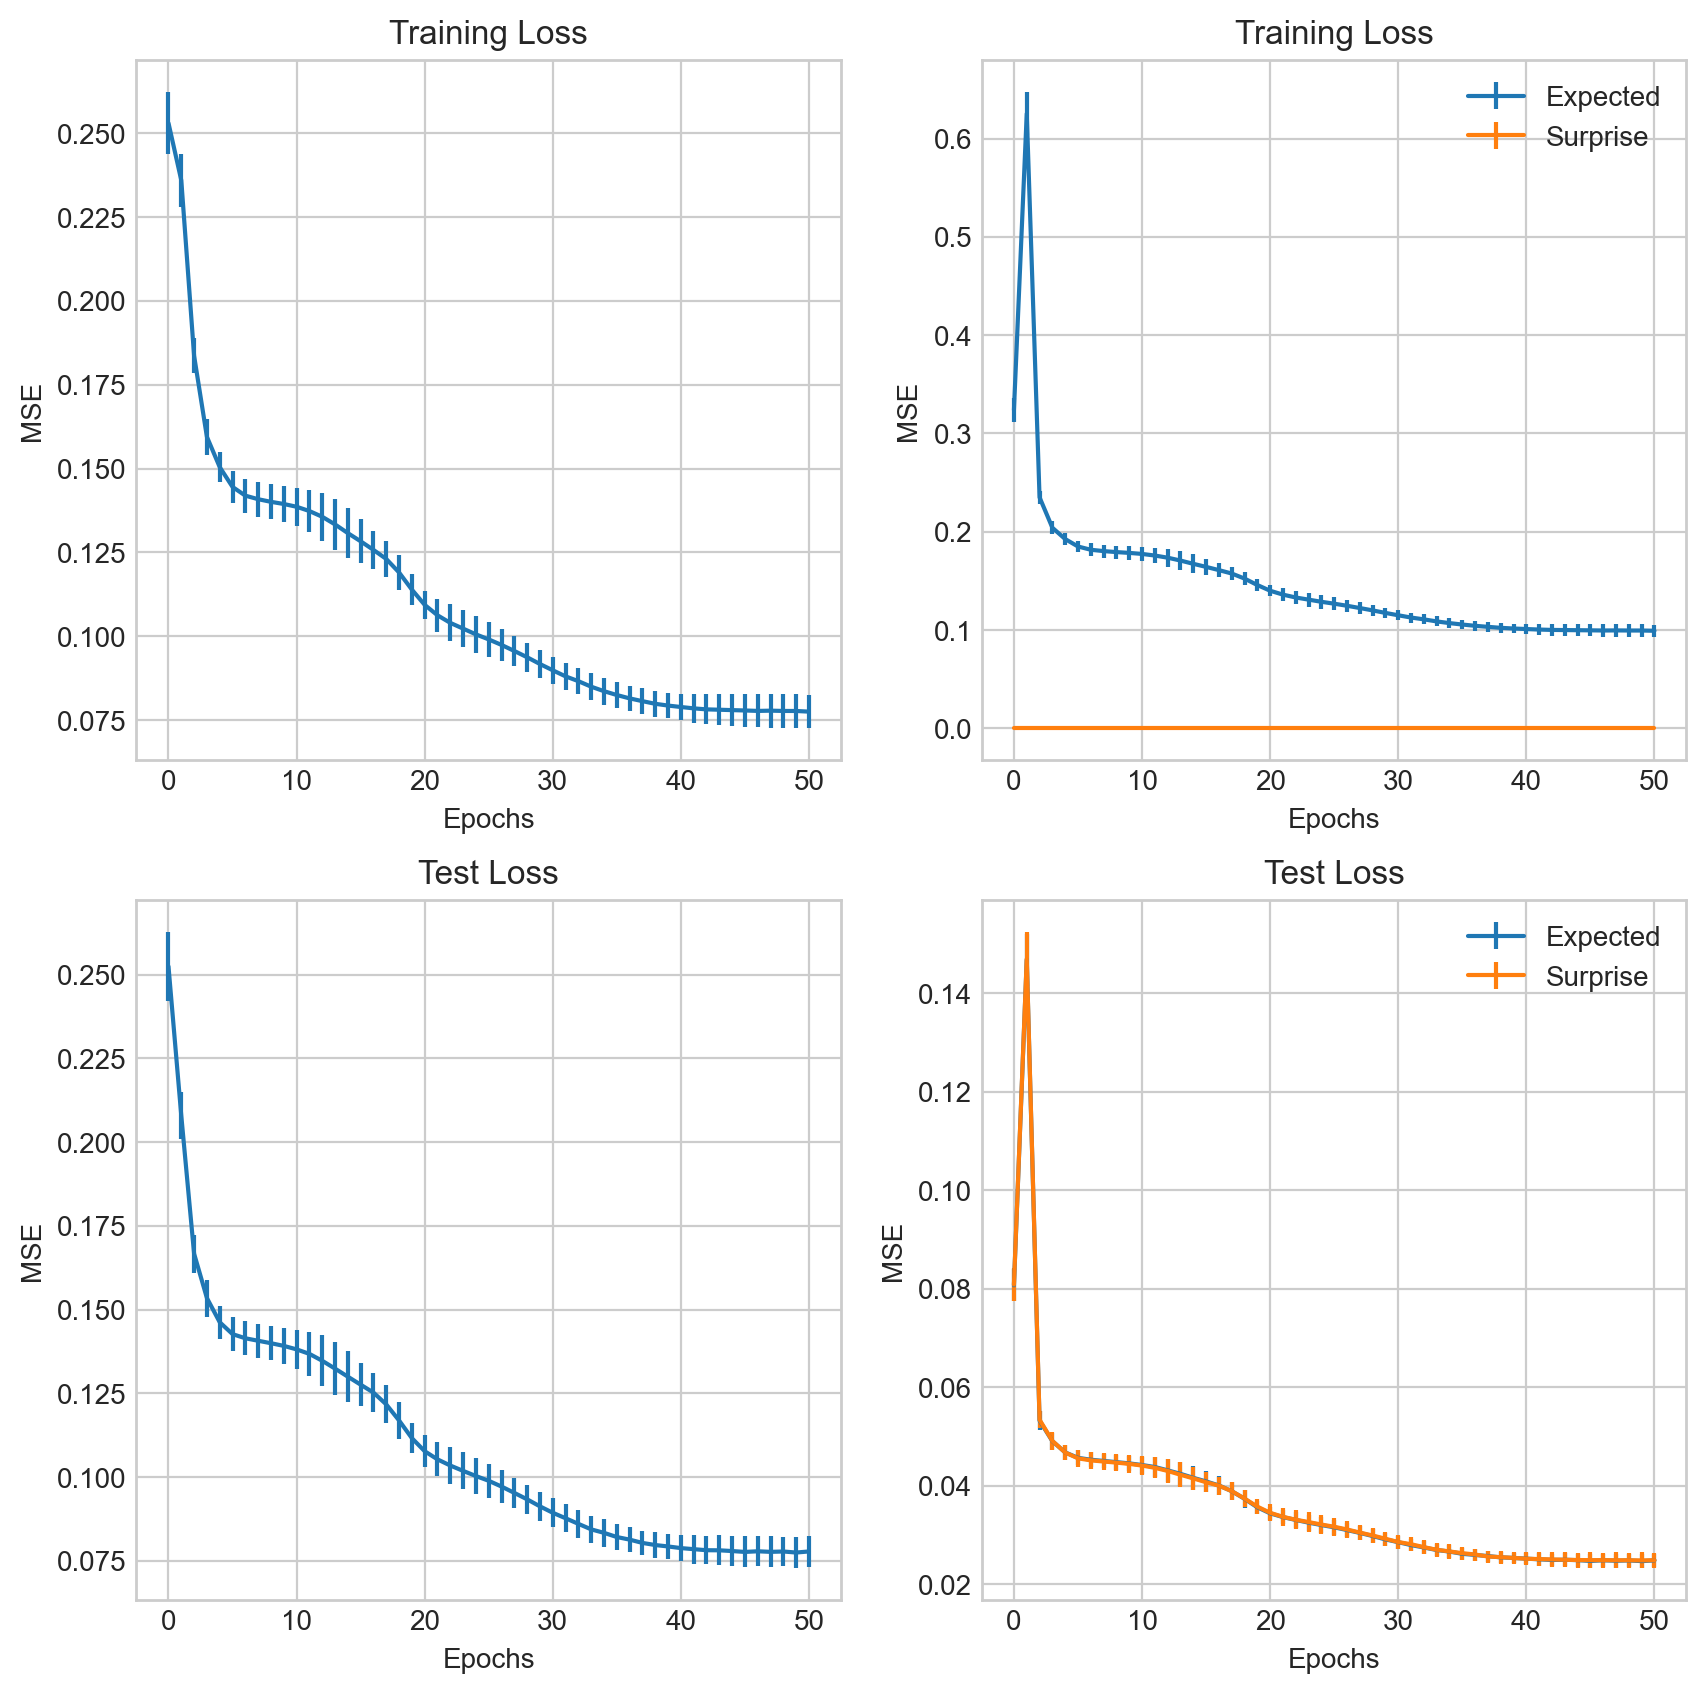

In [48]:
f = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.errorbar(np.arange(n_epochs+1),train_losses_mean,yerr=train_losses_std)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(2,2,2)
plt.errorbar(np.arange(n_epochs+1),train_expected_losses_mean,yerr=train_expected_losses_std,label='Expected')
plt.errorbar(np.arange(n_epochs+1),train_surprise_losses_mean,yerr=train_surprise_losses_std,label='Surprise')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(2,2,3)
plt.errorbar(np.arange(n_epochs+1),test_losses_mean,yerr=test_losses_std)
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(2,2,4)
plt.errorbar(np.arange(n_epochs+1),test_expected_losses_mean,yerr=test_expected_losses_std,label='Expected')
plt.errorbar(np.arange(n_epochs+1),test_surprise_losses_mean,yerr=test_surprise_losses_std,label='Surprise')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()

In [49]:
np.save(pp+'train-losses-corticalRNN',train_losses_mat)
np.save(pp+'test-losses-corticalRNN',test_losses_mat)

np.save(pp+'train-losses-expected-corticalRNN',train_losses_mat)
np.save(pp+'test-losses-expected-corticalRNN',test_losses_mat)

np.save(pp+'train-losses-surprise-corticalRNN',train_losses_mat)
np.save(pp+'test-losses-surprise-corticalRNN',test_losses_mat)

In [50]:
f.savefig('training-testing-error-corticalRNN-V2.png',dpi=300)
f.savefig('training-testing-error-corticalRNN-V2.svg',dpi=300)

### Representational analyses

#### Load clean and surprise sequences

In [51]:
cleanSeqs = cleanSequences
surpSeqs = surpSequences

In [52]:
yCleanSeqs = yCleanSequences
ySurpSeqs = ySurpSequences

In [53]:
eClean = np.array([2,1,2,0,1,0])
pClean = np.ones(nStates_surp,dtype=int)*(-1)
surpClean = np.zeros(nStates_surp,dtype=int)

In [54]:
eSurp = np.array([1,2,0,2,0,1])
pSurp = np.ones(nStates_surp,dtype=int)*2
surpSurp = np.ones(nStates_surp,dtype=int)

#### RNN names

In [55]:
rnn_names = ['L4','L23','L56','H4','H23','H56']

#### Re-initialize models with new batch size

In [56]:
batch_size_analyses = nStates_surp

In [57]:
# model = {}

# for cntr in range(nRuns):
#     model[cntr] = microcircuit(hidden_dim=n_latent,bsize=batch_size_analyses,manual_seed=seeds[cntr])
#     model[cntr].to(device)
#     model[cntr].load_state_dict(torch.load(pp_pts[cntr]+'predRNN_epoch_'+str(e)+'.pt'))
#     model[cntr].eval()

In [58]:
train_loader_analyses = {}
test_loader_analyses = {}

for cntr in range(nRuns):
    train_loader_analyses[cntr] = makeTensorLoaders((cleanSeqs[cntr],yCleanSeqs[cntr],
                                                     eClean,pClean,surpClean),batch_size_analyses,shuffle=False)
    test_loader_analyses[cntr] = makeTensorLoaders((surpSeqs[cntr],ySurpSeqs[cntr],
                                                    eSurp,pSurp,surpSurp),batch_size_analyses,shuffle=False)

#### Pass data through models and store activations

In [59]:
cleanMSE = {}
surpMSE = {}

cleanLosses_exp = {}
cleanLosses_surp = {}

surpLosses_exp = {}
surpLosses_surp = {}

In [60]:
activations_hidden_L23C_np = {}
activations_hidden_L4C_np = {}
activations_hidden_L56C_np = {}

activations_hidden_H23C_np = {}
activations_hidden_H4C_np = {}
activations_hidden_H56C_np = {}

activations_FFC_np = {}
activations_FBaC_np = {}
activations_FBbC_np = {}

activations_outC_np = {}

In [61]:
activations_hidden_L23S_np = {}
activations_hidden_L4S_np = {}
activations_hidden_L56S_np = {}

activations_hidden_H23S_np = {}
activations_hidden_H4S_np = {}
activations_hidden_H56S_np = {}

activations_FFS_np = {}
activations_FBaS_np = {}
activations_FBbS_np = {}

activations_outS_np = {}

In [62]:
for cntr in range(nRuns):
    cleanMSE[cntr] = np.zeros(n_epochs+1)
    surpMSE[cntr] = np.zeros(n_epochs+1)
    
    cleanLosses_exp[cntr] = np.zeros(n_epochs+1)
    cleanLosses_surp[cntr] = np.zeros(n_epochs+1)

    surpLosses_exp[cntr] = np.zeros(n_epochs+1)
    surpLosses_surp[cntr] = np.zeros(n_epochs+1)
    
    activations_hidden_L23C_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[1]*n_latent))
    activations_hidden_L4C_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[0]*n_latent))
    activations_hidden_L56C_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[2]*n_latent))

    activations_hidden_H23C_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[1]*n_latent))
    activations_hidden_H4C_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[0]*n_latent))
    activations_hidden_H56C_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[2]*n_latent))

    activations_FFC_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[0]*n_latent))
    activations_FBaC_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[1]*n_latent))
    activations_FBbC_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[2]*n_latent))

    activations_outC_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,dim))
    
    activations_hidden_L23S_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[1]*n_latent))
    activations_hidden_L4S_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[0]*n_latent))
    activations_hidden_L56S_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[2]*n_latent))

    activations_hidden_H23S_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[1]*n_latent))
    activations_hidden_H4S_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[0]*n_latent))
    activations_hidden_H56S_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[2]*n_latent))

    activations_FFS_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[0]*n_latent))
    activations_FBaS_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[1]*n_latent))
    activations_FBbS_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,pop_list[2]*n_latent))

    activations_outS_np[cntr] = np.zeros((n_epochs+1,nStates_surp,nSteps,dim))

In [63]:
# for cntr in range(nRuns):
#     for e in range(n_epochs+1):
#         model[cntr].load_state_dict(torch.load(pp_pts[cntr]+'predRNN_epoch_'+str(e)+'.pt'))
#         model[cntr].eval()
        
#         for dataC, f_targetC, lastEventC, surprisePositionC, surpriseBinaryC in train_loader_analyses[cntr]:
#             if train_on_gpu:
#                 dataC, f_targetC = dataC.float().cuda(), f_targetC.float().cuda()
#             else: dataC, f_targetC = dataC.float(), f_targetC.float()
                
#             targetC = f_targetC

#             output_predC, RNN_outputsC, feedbackDiffsC, projInterAreaC = model[cntr](dataC)
            
#             print(e)
#             print(np.argmax(output_predC.detach().cpu()@template[cntr].T,-1))
# #             print(np.argmax(dataC.detach().cpu()@template[cntr].T,-1))
# #             print(np.argmax(f_targetC.detach().cpu()@template[cntr].T,-1))
#             print('---------//////////////////---------')


In [64]:
for cntr in range(nRuns):
    
    for e in tqdm(range(n_epochs+1)):

        cntC = 0
        cntS = 0

        ## Load model
        model[cntr] = microcircuit(hidden_dim=n_latent,bsize=batch_size_analyses,manual_seed=seeds[cntr])
        model[cntr].to(device)
        model[cntr].load_state_dict(torch.load(pp_pts[cntr]+'predRNN_epoch_'+str(e)+'.pt'))
        model[cntr].eval()

        ## Pass clean samples
        for dataC, f_targetC, lastEventC, surprisePositionC, surpriseBinaryC in train_loader_analyses[cntr]:

            if train_on_gpu:
                dataC, f_targetC = dataC.float().cuda(), f_targetC.float().cuda()
            else: dataC, f_targetC = dataC.float(), f_targetC.float()

            targetC = f_targetC

            output_predC, RNN_outputsC, feedbackDiffsC, projInterAreaC = model[cntr](dataC)
            lossC = reconLoss(output_predC[:,2:],targetC[:,2:])

            cleanMSE[cntr][e] += lossC.item()*dataC.size(0) #update loss

            errC = torch.linalg.norm((output_predC[:,2:]-targetC[:,2:]),dim=2)
            errSqC = errC**2
            MSE_mat_samples_seqC = errSqC/np.prod(errSqC.shape)
            MSE_samplesC = torch.mean(MSE_mat_samples_seqC,1)
            cleanLosses_exp[cntr][e] += torch.mean(MSE_samplesC[torch.where(surpriseBinaryC==0)[0]])
            if (len(torch.where(surpriseBinaryC==1)[0])>0):
                cleanLosses_surp[cntr][e] += torch.mean(MSE_samplesC[torch.where(surpriseBinaryC==1)[0]])

            ## Collect activations  
            act_hidden_L23C = np.squeeze(RNN_outputsC[0].detach().cpu().numpy())
            act_hidden_L4C = np.squeeze(RNN_outputsC[1].detach().cpu().numpy())
            act_hidden_L56C = np.squeeze(RNN_outputsC[2].detach().cpu().numpy())

            act_hidden_H23C = np.squeeze(RNN_outputsC[3].detach().cpu().numpy())
            act_hidden_H4C = np.squeeze(RNN_outputsC[4].detach().cpu().numpy())
            act_hidden_H56C = np.squeeze(RNN_outputsC[5].detach().cpu().numpy())

            act_FFC = np.squeeze(projInterAreaC[0].detach().cpu().numpy())
            act_FBaC = np.squeeze(projInterAreaC[1].detach().cpu().numpy()) 
            act_FBbC = np.squeeze(projInterAreaC[2].detach().cpu().numpy())

            output_predC = np.squeeze(output_predC.detach().cpu().numpy())

            for i in range(batch_size_analyses):
                if i < len(dataC):
                    label = targetC.data[i]

                    activations_hidden_L23C_np[cntr][e,cntC] = act_hidden_L23C[i]
                    activations_hidden_L4C_np[cntr][e,cntC] = act_hidden_L4C[i]
                    activations_hidden_L56C_np[cntr][e,cntC] = act_hidden_L56C[i]

                    activations_hidden_H23C_np[cntr][e,cntC] = act_hidden_H23C[i]
                    activations_hidden_H4C_np[cntr][e,cntC] = act_hidden_H4C[i]
                    activations_hidden_H56C_np[cntr][e,cntC] = act_hidden_H56C[i]

                    activations_FFC_np[cntr][e,cntC] = act_FFC[i]
                    activations_FBaC_np[cntr][e,cntC] = act_FBaC[i]
                    activations_FBbC_np[cntr][e,cntC] = act_FBbC[i]

                    activations_outC_np[cntr][e,cntC] = output_predC[i]

                    cntC += 1

        #calculate average loss
        cleanMSE[cntr][e] = cleanMSE[cntr][e]/len(train_loader_analyses[cntr].dataset)

        ## Pass surprise samples
        for dataS, f_targetS, lastEventS, surprisePositionS, surpriseBinaryS in test_loader_analyses[cntr]:

            if train_on_gpu:
                dataS, f_targetS = dataS.float().cuda(), f_targetS.float().cuda()
            else: dataS, f_targetS = dataS.float(), f_targetS.float()

            targetS = f_targetS

            output_predS, RNN_outputsS, feedbackDiffsS, projInterAreaS = model[cntr](dataS)
            lossS = reconLoss(output_predS[:,2:],targetS[:,2:])

            surpMSE[cntr][e] += lossS.item()*dataS.size(0) #update loss

            errS = torch.linalg.norm((output_predS[:,2:]-targetS[:,2:]),dim=2)
            errSqS = errC**2
            MSE_mat_samples_seqS = errSqS/np.prod(errSqS.shape)
            MSE_samplesS = torch.mean(MSE_mat_samples_seqS,1)
            surpLosses_exp[cntr][e] += torch.mean(MSE_samplesS[torch.where(surpriseBinaryS==0)[0]])
            if (len(torch.where(surpriseBinaryS==1)[0])>0):
                surpLosses_surp[cntr][e] += torch.mean(MSE_samplesS[torch.where(surpriseBinaryS==1)[0]])

            ## Collect activations  
            act_hidden_L23S = np.squeeze(RNN_outputsS[0].detach().cpu().numpy())
            act_hidden_L4S = np.squeeze(RNN_outputsS[1].detach().cpu().numpy())
            act_hidden_L56S = np.squeeze(RNN_outputsS[2].detach().cpu().numpy())

            act_hidden_H23S = np.squeeze(RNN_outputsS[3].detach().cpu().numpy())
            act_hidden_H4S = np.squeeze(RNN_outputsS[4].detach().cpu().numpy())
            act_hidden_H56S = np.squeeze(RNN_outputsS[5].detach().cpu().numpy())

            act_FFS = np.squeeze(projInterAreaS[0].detach().cpu().numpy())
            act_FBaS = np.squeeze(projInterAreaS[1].detach().cpu().numpy()) 
            act_FBbS = np.squeeze(projInterAreaS[2].detach().cpu().numpy())

            output_predS = np.squeeze(output_predS.detach().cpu().numpy())

            for i in range(batch_size):
                if i < len(dataS):
                    labelS = targetS.data[i]

                    activations_hidden_L23S_np[cntr][e,cntS] = act_hidden_L23S[i]
                    activations_hidden_L4S_np[cntr][e,cntS] = act_hidden_L4S[i]
                    activations_hidden_L56S_np[cntr][e,cntS] = act_hidden_L56S[i]

                    activations_hidden_H23S_np[cntr][e,cntS] = act_hidden_H23S[i]
                    activations_hidden_H4S_np[cntr][e,cntS] = act_hidden_H4S[i]
                    activations_hidden_H56S_np[cntr][e,cntS] = act_hidden_H56S[i]

                    activations_FFS_np[cntr][e,cntS] = act_FFS[i]
                    activations_FBaS_np[cntr][e,cntS] = act_FBaS[i]
                    activations_FBbS_np[cntr][e,cntS] = act_FBbS[i]

                    activations_outS_np[cntr][e,cntS] = output_predS[i]

                    cntS += 1

        #calculate average loss
        surpMSE[cntr][e] = surpMSE[cntr][e]/len(test_loader_analyses[cntr].dataset)

100%|██████████| 51/51 [00:03<00:00, 14.89it/s]


#### Image ID matrices

In [65]:
imgID_mtxC = np.zeros((nStates_surp,lenSeq*nRepeats),dtype=int)
imgID_mtxS = np.zeros((nStates_surp,lenSeq*nRepeats),dtype=int)

all_perm_list = list(permutations(np.arange(nStates_reg)))

for jj in range(nStates_surp):
    imgID_mtxC[jj,:-2:2] = all_perm_list[jj]
    imgID_mtxC[jj,1:-2:2] = all_perm_list[jj]
    
    imgID_mtxS[jj,:-2:2] = all_perm_list[jj]
    imgID_mtxS[jj,1:-2:2] = all_perm_list[jj]
    
    imgID_mtxS[jj,-4:-2] = imgID_mtxS[jj,2:4]
    
    imgID_mtxC[jj,-2:] = jj+nStates_reg
    imgID_mtxS[jj,-2:] = jj+nStates_reg

#### Label Matrices

In [66]:
labelNames = ['inputID','outputID','seqID','inputSurpBinary', 'outputSurpBinary','seqPosition',
              ' inputSurpType', 'outputSurpType','timestep']

In [67]:
## Initialize appropriately sized label matrices

labelMtxC = np.zeros((nStates_surp*nSteps,len(labelNames)),dtype=int)
labelMtxS = np.zeros((nStates_surp*nSteps,len(labelNames)),dtype=int)

In [68]:
labelMtxC[:,0] = np.repeat(imgID_mtxC[:,0:-2:2].ravel(),nRepeats)
labelMtxS[:,0] = np.repeat(imgID_mtxS[:,0:-2:2].ravel(),nRepeats)

labelMtxC[:,1] = np.repeat(imgID_mtxC[:,2::2].ravel(),nRepeats)
labelMtxS[:,1] = np.repeat(imgID_mtxS[:,2::2].ravel(),nRepeats)

labelMtxC[:,2] = np.repeat(imgID_mtxC[:,-1],nSteps)
labelMtxS[:,2] = np.repeat(imgID_mtxS[:,-1],nSteps)

ii = np.zeros(nSteps,dtype=int)
ii[-nRepeats:]=1
ii = np.tile(ii,nStates_surp)

labelMtxS[:,3] = ii

oo = np.ones(nSteps,dtype=int)
oo[:nRepeats]=0
oo = np.tile(oo,nStates_surp)

labelMtxS[:,4] = oo

labelMtxC[:,5] = np.tile(np.repeat(np.array([0,1,2]),nRepeats),nStates_surp)
labelMtxS[:,5] = np.tile(np.repeat(np.array([0,1,2]),nRepeats),nStates_surp)

In [69]:
labelMtxS[:,6] = labelMtxS[:,3]
labelMtxS[:,7] = labelMtxS[:,5]

In [70]:
labelMtxC[:,8] = np.array([x%nSteps for x in range(nStates_surp*nSteps)])
labelMtxS[:,8] = np.array([x%nSteps for x in range(nStates_surp*nSteps)])

0 = inputID = image being fed as input <br>
1 = outputID = image to be predicted at output <br>
2 = seqID = last element of the sequence (sequence label) <br>
3 = inputSurpBinary = if image being fed is any kind of surprise <br>
4 = outputSurpBinary = if image being predicted is any kind of surprise <br>
5 = seqPosition = which element of the sequence is being processed <br>

#### PCA for RNNs

In [71]:
def repsPCA(rnnActs):
    nEpochs, nSeqs, nRolls, nNeurons = rnnActs.shape
    pca_dict = {}
    nSamps = nSeqs*nRolls
    dimPCA = min(nNeurons,nSamps)
    repsR_transformed = np.zeros((nEpochs,nSamps,dimPCA))
    
    for ep in tqdm(range(nEpochs)):
        
        reps = rnnActs[ep]
        
        ## reshape
        repsR = np.zeros((nSeqs*nRolls,nNeurons))
        cnt = 0
        for ii in range(nSeqs):
            for jj in range(nRolls):
                repsR[cnt] = reps[ii,jj]
                cnt += 1
        ## PCA
        rnnPCA = PCA()
        repsR_transformed[ep] = rnnPCA.fit_transform(repsR)
        pca_dict[str(ep)] = rnnPCA
        
    return repsR_transformed, pca_dict

In [72]:
L23pcaC = {}
L4pcaC = {}
L56pcaC = {}

H23pcaC = {}
H4pcaC = {}
H56pcaC = {}

L23pcaS = {}
L4pcaS = {}
L56pcaS = {}

H23pcaS = {}
H4pcaS = {}
H56pcaS = {}

In [73]:
for cntr in range(nRuns):
    L23pcaC[cntr], _ = repsPCA(activations_hidden_L23C_np[cntr])
    L4pcaC[cntr], _ = repsPCA(activations_hidden_L4C_np[cntr])
    L56pcaC[cntr], _ = repsPCA(activations_hidden_L56C_np[cntr])

    H23pcaC[cntr], _ = repsPCA(activations_hidden_H23C_np[cntr])
    H4pcaC[cntr], _ = repsPCA(activations_hidden_H4C_np[cntr])
    H56pcaC[cntr], _ = repsPCA(activations_hidden_H56C_np[cntr])

100%|██████████| 51/51 [00:00<00:00, 648.44it/s]


In [74]:
for cntr in range(nRuns):
    L23pcaS[cntr], _ = repsPCA(activations_hidden_L23S_np[cntr])
    L4pcaS[cntr], _ = repsPCA(activations_hidden_L4S_np[cntr])
    L56pcaS[cntr], _ = repsPCA(activations_hidden_L56S_np[cntr])

    H23pcaS[cntr], _ = repsPCA(activations_hidden_H23S_np[cntr])
    H4pcaS[cntr], _ = repsPCA(activations_hidden_H4S_np[cntr])
    H56pcaS[cntr], _ = repsPCA(activations_hidden_H56S_np[cntr])

100%|██████████| 51/51 [00:00<00:00, 629.64it/s]


#### Subset indices, etc.

In [75]:
idxs2 = np.array([4,5,10,11,16,17,22,23,28,29,34,35])
idxs0 = idxs2 - 4
idxs1 = idxs2 - 2

In [76]:
exp0s = np.array([22,23,34,35])
exp1s = np.array([10,11,28,29])
exp2s = np.array([4,5,16,17])

In [77]:
surp0s = np.array([16,17,28,29])
surp1s = np.array([4,5,34,35])
surp2s = np.array([10,11,22,23])

In [78]:
cleanPCs = {}
surpPCs = {}

contextPCs_sub = {}

In [79]:
for cntr in range(nRuns):
    cleanPCs[cntr] = (L4pcaC[cntr],L23pcaC[cntr],L56pcaC[cntr],H4pcaC[cntr],H23pcaC[cntr],H56pcaC[cntr])
    surpPCs[cntr] = (L4pcaS[cntr],L23pcaS[cntr],L56pcaS[cntr],H4pcaS[cntr],H23pcaS[cntr],H56pcaS[cntr])
    
    for rnnNo in range(len(rnn_names)):
        contextPCs_sub[cntr,rnnNo] = np.hstack((cleanPCs[cntr][rnnNo][:,idxs2,:],surpPCs[cntr][rnnNo][:,idxs2,:]))

In [80]:
context_sub_imgIDs = np.array([2,2,1,1,2,2,0,0,1,1,0,0,1,1,2,2,0,0,2,2,0,0,1,1])
context_sub_surp = np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1])

#### Context plots

In [81]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [82]:
legend_elements = [Line2D([0], [0], marker='o', color='r', label='Expected As'),
                   Line2D([0], [0], marker='o', color='g', label='Expected Bs'),
                   Line2D([0], [0], marker='o', color='b', label='Expected Cs'),
                   Line2D([0], [0], marker='x', color='r', label='Surprise As'),
                   Line2D([0], [0], marker='x', color='g', label='Surprise Bs'),
                   Line2D([0], [0], marker='x', color='b', label='Surprise Cs')]
# Create the figure
# fig, ax = plt.subplots()
# plt.legend(handles=legend_elements, loc='best')
# plt.show()

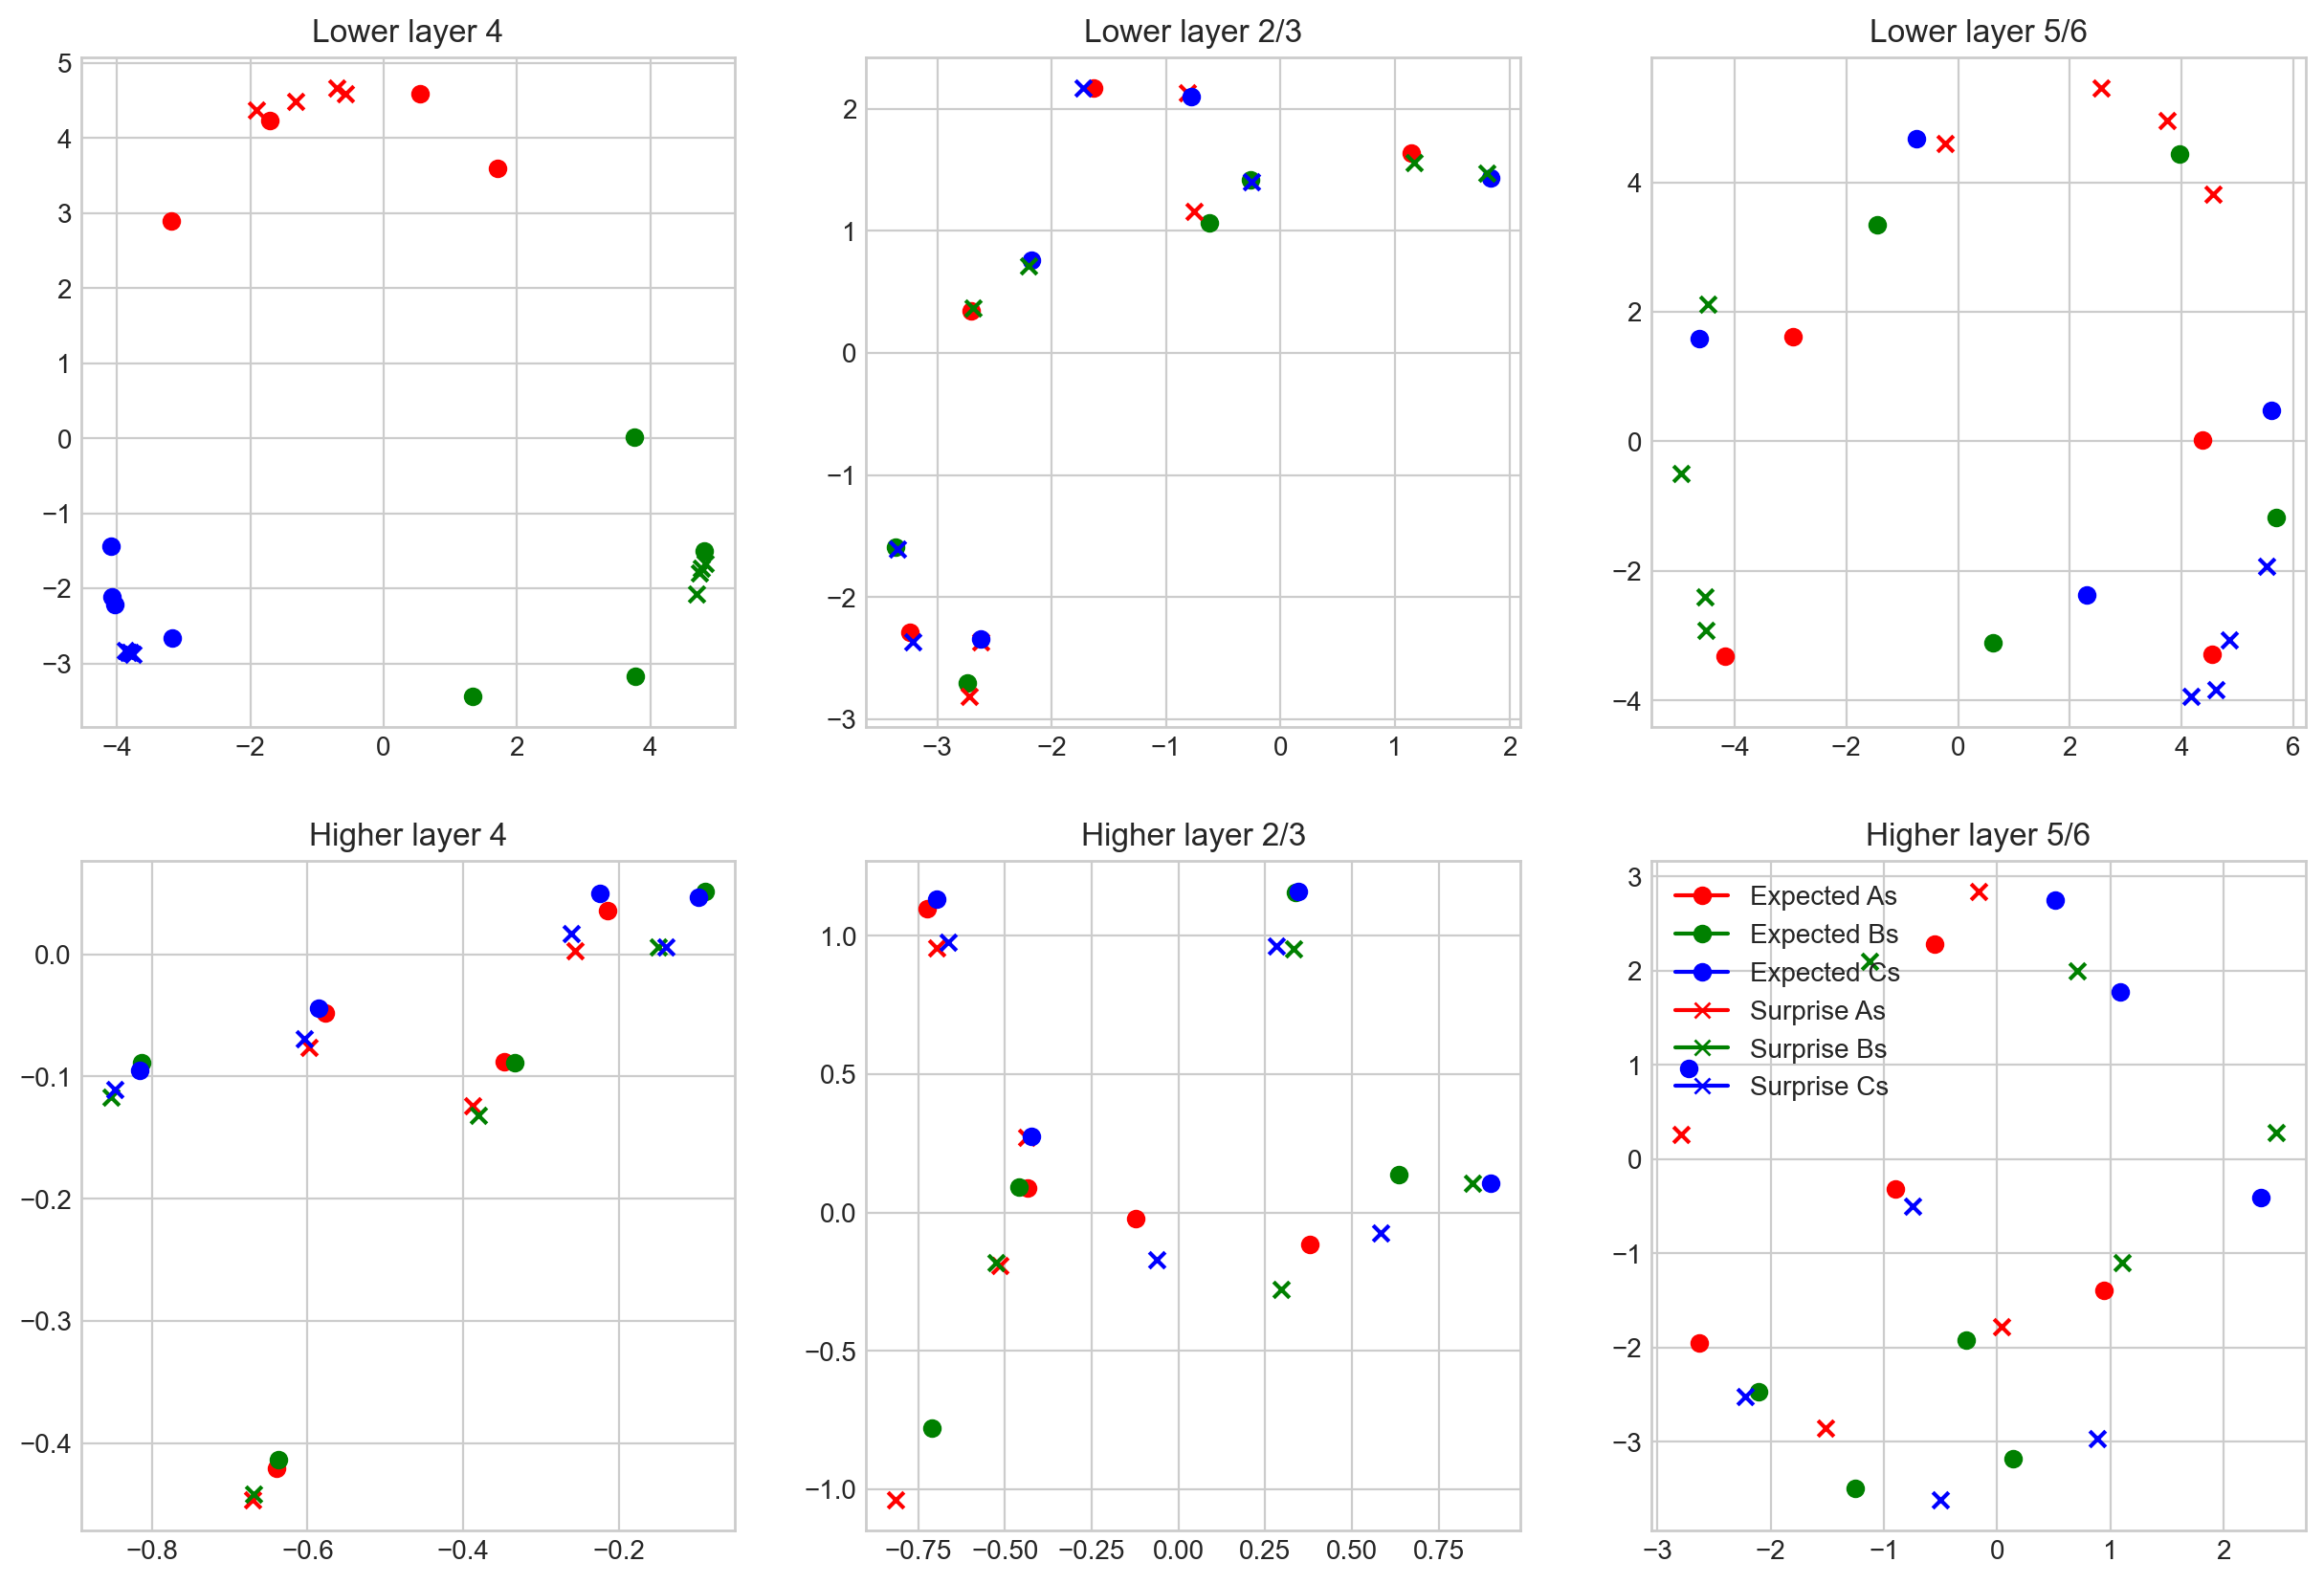

In [83]:
kkk = 1 ##1
e = -1

ff, axs = plt.subplots(2,3,figsize=(15,10))

for ii in range(len(exp0s)):
    axs[0,0].scatter(cleanPCs[kkk][0][e,exp0s[ii],0],cleanPCs[kkk][0][e,exp0s[ii],1],c='r',marker='o')
    axs[0,0].scatter(cleanPCs[kkk][0][e,exp1s[ii],0],cleanPCs[kkk][0][e,exp1s[ii],1],c='g',marker='o')
    axs[0,0].scatter(cleanPCs[kkk][0][e,exp2s[ii],0],cleanPCs[kkk][0][e,exp2s[ii],1],c='b',marker='o')
    
    axs[0,0].scatter(surpPCs[kkk][0][e,surp0s[ii],0],surpPCs[kkk][0][e,surp0s[ii],1],c='r',marker='x')
    axs[0,0].scatter(surpPCs[kkk][0][e,surp1s[ii],0],surpPCs[kkk][0][e,surp1s[ii],1],c='g',marker='x')
    axs[0,0].scatter(surpPCs[kkk][0][e,surp2s[ii],0],surpPCs[kkk][0][e,surp2s[ii],1],c='b',marker='x')
    axs[0,0].set_title('Lower layer 4')
    
for ii in range(len(exp0s)):
    axs[0,1].scatter(cleanPCs[kkk][1][e,exp0s[ii],0],cleanPCs[kkk][1][e,exp0s[ii],1],c='r',marker='o')
    axs[0,1].scatter(cleanPCs[kkk][1][e,exp1s[ii],0],cleanPCs[kkk][1][e,exp1s[ii],1],c='g',marker='o')
    axs[0,1].scatter(cleanPCs[kkk][1][e,exp2s[ii],0],cleanPCs[kkk][1][e,exp2s[ii],1],c='b',marker='o')
    
    axs[0,1].scatter(surpPCs[kkk][1][e,surp0s[ii],0],surpPCs[kkk][1][e,surp0s[ii],1],c='r',marker='x')
    axs[0,1].scatter(surpPCs[kkk][1][e,surp1s[ii],0],surpPCs[kkk][1][e,surp1s[ii],1],c='g',marker='x')
    axs[0,1].scatter(surpPCs[kkk][1][e,surp2s[ii],0],surpPCs[kkk][1][e,surp2s[ii],1],c='b',marker='x')
    axs[0,1].set_title('Lower layer 2/3')
    
for ii in range(len(exp0s)):
    axs[0,2].scatter(cleanPCs[kkk][2][e,exp0s[ii],0],cleanPCs[kkk][2][e,exp0s[ii],1],c='r',marker='o')
    axs[0,2].scatter(cleanPCs[kkk][2][e,exp1s[ii],0],cleanPCs[kkk][2][e,exp1s[ii],1],c='g',marker='o')
    axs[0,2].scatter(cleanPCs[kkk][2][e,exp2s[ii],0],cleanPCs[kkk][2][e,exp2s[ii],1],c='b',marker='o')
    
    axs[0,2].scatter(surpPCs[kkk][2][e,surp0s[ii],0],surpPCs[kkk][2][e,surp0s[ii],1],c='r',marker='x')
    axs[0,2].scatter(surpPCs[kkk][2][e,surp1s[ii],0],surpPCs[kkk][2][e,surp1s[ii],1],c='g',marker='x')
    axs[0,2].scatter(surpPCs[kkk][2][e,surp2s[ii],0],surpPCs[kkk][2][e,surp2s[ii],1],c='b',marker='x')
    axs[0,2].set_title('Lower layer 5/6')
    
for ii in range(len(exp0s)):
    axs[1,0].scatter(cleanPCs[kkk][3][e,exp0s[ii],0],cleanPCs[kkk][3][e,exp0s[ii],1],c='r',marker='o')
    axs[1,0].scatter(cleanPCs[kkk][3][e,exp1s[ii],0],cleanPCs[kkk][3][e,exp1s[ii],1],c='g',marker='o')
    axs[1,0].scatter(cleanPCs[kkk][3][e,exp2s[ii],0],cleanPCs[kkk][3][e,exp2s[ii],1],c='b',marker='o')
    
    axs[1,0].scatter(surpPCs[kkk][3][e,surp0s[ii],0],surpPCs[kkk][3][e,surp0s[ii],1],c='r',marker='x')
    axs[1,0].scatter(surpPCs[kkk][3][e,surp1s[ii],0],surpPCs[kkk][3][e,surp1s[ii],1],c='g',marker='x')
    axs[1,0].scatter(surpPCs[kkk][3][e,surp2s[ii],0],surpPCs[kkk][3][e,surp2s[ii],1],c='b',marker='x')
    axs[1,0].set_title('Higher layer 4')
    
for ii in range(len(exp0s)):
    axs[1,1].scatter(cleanPCs[kkk][4][e,exp0s[ii],0],cleanPCs[kkk][4][e,exp0s[ii],1],c='r',marker='o')
    axs[1,1].scatter(cleanPCs[kkk][4][e,exp1s[ii],0],cleanPCs[kkk][4][e,exp1s[ii],1],c='g',marker='o')
    axs[1,1].scatter(cleanPCs[kkk][4][e,exp2s[ii],0],cleanPCs[kkk][4][e,exp2s[ii],1],c='b',marker='o')
    
    axs[1,1].scatter(surpPCs[kkk][4][e,surp0s[ii],0],surpPCs[kkk][4][e,surp0s[ii],1],c='r',marker='x')
    axs[1,1].scatter(surpPCs[kkk][4][e,surp1s[ii],0],surpPCs[kkk][4][e,surp1s[ii],1],c='g',marker='x')
    axs[1,1].scatter(surpPCs[kkk][4][e,surp2s[ii],0],surpPCs[kkk][4][e,surp2s[ii],1],c='b',marker='x')
    axs[1,1].set_title('Higher layer 2/3')
    
for ii in range(len(exp0s)):
    axs[1,2].scatter(cleanPCs[kkk][5][e,exp0s[ii],0],cleanPCs[kkk][5][e,exp0s[ii],1],c='r',marker='o')
    axs[1,2].scatter(cleanPCs[kkk][5][e,exp1s[ii],0],cleanPCs[kkk][5][e,exp1s[ii],1],c='g',marker='o')
    axs[1,2].scatter(cleanPCs[kkk][5][e,exp2s[ii],0],cleanPCs[kkk][5][e,exp2s[ii],1],c='b',marker='o')
    
    axs[1,2].scatter(surpPCs[kkk][5][e,surp0s[ii],0],surpPCs[kkk][5][e,surp0s[ii],1],c='r',marker='x')
    axs[1,2].scatter(surpPCs[kkk][5][e,surp1s[ii],0],surpPCs[kkk][5][e,surp1s[ii],1],c='g',marker='x')
    axs[1,2].scatter(surpPCs[kkk][5][e,surp2s[ii],0],surpPCs[kkk][5][e,surp2s[ii],1],c='b',marker='x')
    axs[1,2].set_title('Higher layer 5/6')
plt.legend(handles=legend_elements, loc='best')
plt.show()

In [84]:
ff.savefig('example-corticalRNN-no-td-pc-plots-V2.png',dpi=300)
ff.savefig('example-corticalRNN-no-td-pc-plots-V2.svg',dpi=300)

In [85]:
# kkk = 4
# e = 0

# ff, axs = plt.subplots(2,3,figsize=(15,10))

# for ii in range(len(exp0s)):
#     axs[0,0].scatter(cleanPCs[kkk][0][e,exp0s[ii],0],cleanPCs[kkk][0][e,exp0s[ii],0],c='r',marker='o')
#     axs[0,0].scatter(cleanPCs[kkk][0][e,exp1s[ii],0],cleanPCs[kkk][0][e,exp1s[ii],0],c='g',marker='o')
#     axs[0,0].scatter(cleanPCs[kkk][0][e,exp2s[ii],0],cleanPCs[kkk][0][e,exp2s[ii],0],c='b',marker='o')
    
#     axs[0,0].scatter(surpPCs[kkk][0][e,surp0s[ii],0],surpPCs[kkk][0][e,surp0s[ii],0],c='r',marker='x')
#     axs[0,0].scatter(surpPCs[kkk][0][e,surp1s[ii],0],surpPCs[kkk][0][e,surp1s[ii],0],c='g',marker='x')
#     axs[0,0].scatter(surpPCs[kkk][0][e,surp2s[ii],0],surpPCs[kkk][0][e,surp2s[ii],0],c='b',marker='x')
#     axs[0,0].set_title('L4')
    
# for ii in range(len(exp0s)):
#     axs[0,1].scatter(cleanPCs[kkk][1][e,exp0s[ii],0],cleanPCs[kkk][1][e,exp0s[ii],0],c='r',marker='o')
#     axs[0,1].scatter(cleanPCs[kkk][1][e,exp1s[ii],0],cleanPCs[kkk][1][e,exp1s[ii],0],c='g',marker='o')
#     axs[0,1].scatter(cleanPCs[kkk][1][e,exp2s[ii],0],cleanPCs[kkk][1][e,exp2s[ii],0],c='b',marker='o')
    
#     axs[0,1].scatter(surpPCs[kkk][1][e,surp0s[ii],0],surpPCs[kkk][1][e,surp0s[ii],0],c='r',marker='x')
#     axs[0,1].scatter(surpPCs[kkk][1][e,surp1s[ii],0],surpPCs[kkk][1][e,surp1s[ii],0],c='g',marker='x')
#     axs[0,1].scatter(surpPCs[kkk][1][e,surp2s[ii],0],surpPCs[kkk][1][e,surp2s[ii],0],c='b',marker='x')
#     axs[0,1].set_title('L2/3')
    
# for ii in range(len(exp0s)):
#     axs[0,2].scatter(cleanPCs[kkk][2][e,exp0s[ii],0],cleanPCs[kkk][2][e,exp0s[ii],0],c='r',marker='o')
#     axs[0,2].scatter(cleanPCs[kkk][2][e,exp1s[ii],0],cleanPCs[kkk][2][e,exp1s[ii],0],c='g',marker='o')
#     axs[0,2].scatter(cleanPCs[kkk][2][e,exp2s[ii],0],cleanPCs[kkk][2][e,exp2s[ii],0],c='b',marker='o')
    
#     axs[0,2].scatter(surpPCs[kkk][2][e,surp0s[ii],0],surpPCs[kkk][2][e,surp0s[ii],0],c='r',marker='x')
#     axs[0,2].scatter(surpPCs[kkk][2][e,surp1s[ii],0],surpPCs[kkk][2][e,surp1s[ii],0],c='g',marker='x')
#     axs[0,2].scatter(surpPCs[kkk][2][e,surp2s[ii],0],surpPCs[kkk][2][e,surp2s[ii],0],c='b',marker='x')
#     axs[0,2].set_title('L5/6')
    
# for ii in range(len(exp0s)):
#     axs[1,0].scatter(cleanPCs[kkk][3][e,exp0s[ii],0],cleanPCs[kkk][3][e,exp0s[ii],0],c='r',marker='o')
#     axs[1,0].scatter(cleanPCs[kkk][3][e,exp1s[ii],0],cleanPCs[kkk][3][e,exp1s[ii],0],c='g',marker='o')
#     axs[1,0].scatter(cleanPCs[kkk][3][e,exp2s[ii],0],cleanPCs[kkk][3][e,exp2s[ii],0],c='b',marker='o')
    
#     axs[1,0].scatter(surpPCs[kkk][3][e,surp0s[ii],0],surpPCs[kkk][3][e,surp0s[ii],0],c='r',marker='x')
#     axs[1,0].scatter(surpPCs[kkk][3][e,surp1s[ii],0],surpPCs[kkk][3][e,surp1s[ii],0],c='g',marker='x')
#     axs[1,0].scatter(surpPCs[kkk][3][e,surp2s[ii],0],surpPCs[kkk][3][e,surp2s[ii],0],c='b',marker='x')
#     axs[1,0].set_title('H4')
    
# for ii in range(len(exp0s)):
#     axs[1,1].scatter(cleanPCs[kkk][4][e,exp0s[ii],0],cleanPCs[kkk][4][e,exp0s[ii],0],c='r',marker='o')
#     axs[1,1].scatter(cleanPCs[kkk][4][e,exp1s[ii],0],cleanPCs[kkk][4][e,exp1s[ii],0],c='g',marker='o')
#     axs[1,1].scatter(cleanPCs[kkk][4][e,exp2s[ii],0],cleanPCs[kkk][4][e,exp2s[ii],0],c='b',marker='o')
    
#     axs[1,1].scatter(surpPCs[kkk][4][e,surp0s[ii],0],surpPCs[kkk][4][e,surp0s[ii],0],c='r',marker='x')
#     axs[1,1].scatter(surpPCs[kkk][4][e,surp1s[ii],0],surpPCs[kkk][4][e,surp1s[ii],0],c='g',marker='x')
#     axs[1,1].scatter(surpPCs[kkk][4][e,surp2s[ii],0],surpPCs[kkk][4][e,surp2s[ii],0],c='b',marker='x')
#     axs[1,1].set_title('H2/3')
    
# for ii in range(len(exp0s)):
#     axs[1,2].scatter(cleanPCs[kkk][5][e,exp0s[ii],0],cleanPCs[kkk][5][e,exp0s[ii],0],c='r',marker='o')
#     axs[1,2].scatter(cleanPCs[kkk][5][e,exp1s[ii],0],cleanPCs[kkk][5][e,exp1s[ii],0],c='g',marker='o')
#     axs[1,2].scatter(cleanPCs[kkk][5][e,exp2s[ii],0],cleanPCs[kkk][5][e,exp2s[ii],0],c='b',marker='o')
    
#     axs[1,2].scatter(surpPCs[kkk][5][e,surp0s[ii],0],surpPCs[kkk][5][e,surp0s[ii],0],c='r',marker='x')
#     axs[1,2].scatter(surpPCs[kkk][5][e,surp1s[ii],0],surpPCs[kkk][5][e,surp1s[ii],0],c='g',marker='x')
#     axs[1,2].scatter(surpPCs[kkk][5][e,surp2s[ii],0],surpPCs[kkk][5][e,surp2s[ii],0],c='b',marker='x')
#     axs[1,2].set_title('H5/6')

#### Supervised Decoding - Original Representations - Confusion Matrices

In [86]:
def repsDecodeSupervised(rnnActs,labels,decodeType='surprise',clf='svm'):
    nEpochs, nSeqs, nRolls, nNeurons = rnnActs.shape
    decode_dict = {}
    nSamps = nSeqs*nRolls
    
    if decodeType == 'surprise':
        nClasses = 2
    elif decodeType == 'imageID':
        nClasses = nStates_reg
    elif decodeType == 'timestep':
        nClasses = nSteps
    
    reps_preds_probs = np.zeros((nEpochs,nSamps,nClasses))
    
    for ep in tqdm(range(nEpochs)):
        
        reps = rnnActs[ep]
        
        ## reshape
        repsR = np.zeros((nSeqs*nRolls,nNeurons))
        cnt = 0
        for ii in range(nSeqs):
            for jj in range(nRolls):
                repsR[cnt] = reps[ii,jj]
                cnt += 1
        
        ## Decoding
        if clf=='svm':
            clfR = SVC(kernel='linear',probability=True).fit(repsR,labels)
        elif clf=='logistic':
            clfR = LogisticRegression().fit(repsR,labels)
        elif clf=='perceptron':
            clfR = Perceptron().fit(repsR,labels)
        
        reps_preds_probs[ep] = clfR.predict_proba(repsR)
        decode_dict[str(ep)] = clfR
        
    return reps_preds_probs, decode_dict

In [87]:
# L23sdC = {}
# L4sdC = {}
# L56sdC = {}

# H23sdC = {}
# H4sdC = {}
# H56sdC = {}

# L23sdS = {}
# L4sdS = {}
# L56sdS = {}

# H23sdS = {}
# H4sdS = {}
# H56sdS = {}

In [88]:
# L23sd1C = {}
# L4sd1C = {}
# L56sd1C = {}

# H23sd1C = {}
# H4sd1C = {}
# H56sd1C = {}

# L23sd1S = {}
# L4sd1S = {}
# L56sd1S = {}

# H23sd1S = {}
# H4sd1S = {}
# H56sd1S = {}

In [89]:
# L23sd2C = {}
# L4sd2C = {}
# L56sd2C = {}

# H23sd2C = {}
# H4sd2C = {}
# H56sd2C = {}

# L23sd2S = {}
# L4sd2S = {}
# L56sd2S = {}

# H23sd2S = {}
# H4sd2S = {}
# H56sd2S = {}

In [90]:
# L23sd3S = {}
# L4sd3S = {}
# L56sd3S = {}

# H23sd3S = {}
# H4sd3S = {}
# H56sd3S = {}

In [91]:
# for cntr in range(nRuns):
#     ## Clean, ImageID
#     L23sdC[cntr], _ = repsDecodeSupervised(activations_hidden_L23C_np[cntr],labelMtxC[:,0],decodeType='imageID')
#     L4sdC[cntr], _ = repsDecodeSupervised(activations_hidden_L4C_np[cntr],labelMtxC[:,0],decodeType='imageID')
#     L56sdC[cntr], _ = repsDecodeSupervised(activations_hidden_L56C_np[cntr],labelMtxC[:,0],decodeType='imageID')

#     H23sdC[cntr], _ = repsDecodeSupervised(activations_hidden_H23C_np[cntr],labelMtxC[:,0],decodeType='imageID')
#     H4sdC[cntr], _ = repsDecodeSupervised(activations_hidden_H4C_np[cntr],labelMtxC[:,0],decodeType='imageID')
#     H56sdC[cntr], _ = repsDecodeSupervised(activations_hidden_H56C_np[cntr],labelMtxC[:,0],decodeType='imageID')
    
#     ## Surprise, ImageID
#     L23sdS[cntr], _ = repsDecodeSupervised(activations_hidden_L23S_np[cntr],labelMtxS[:,0],decodeType='imageID')
#     L4sdS[cntr], _ = repsDecodeSupervised(activations_hidden_L4S_np[cntr],labelMtxS[:,0],decodeType='imageID')
#     L56sdS[cntr], _ = repsDecodeSupervised(activations_hidden_L56S_np[cntr],labelMtxS[:,0],decodeType='imageID')

#     H23sdS[cntr], _ = repsDecodeSupervised(activations_hidden_H23S_np[cntr],labelMtxS[:,0],decodeType='imageID')
#     H4sdS[cntr], _ = repsDecodeSupervised(activations_hidden_H4S_np[cntr],labelMtxS[:,0],decodeType='imageID')
#     H56sdS[cntr], _ = repsDecodeSupervised(activations_hidden_H56S_np[cntr],labelMtxS[:,0],decodeType='imageID')
    
#     ## Clean, Timestep
#     L23sd2C[cntr], _ = repsDecodeSupervised(activations_hidden_L23C_np[cntr],labelMtxC[:,-1],decodeType='timestep')
#     L4sd2C[cntr], _ = repsDecodeSupervised(activations_hidden_L4C_np[cntr],labelMtxC[:,-1],decodeType='timestep')
#     L56sd2C[cntr], _ = repsDecodeSupervised(activations_hidden_L56C_np[cntr],labelMtxC[:,-1],decodeType='timestep')

#     H23sd2C[cntr], _ = repsDecodeSupervised(activations_hidden_H23C_np[cntr],labelMtxC[:,-1],decodeType='timestep')
#     H4sd2C[cntr], _ = repsDecodeSupervised(activations_hidden_H4C_np[cntr],labelMtxC[:,-1],decodeType='timestep')
#     H56sd2C[cntr], _ = repsDecodeSupervised(activations_hidden_H56C_np[cntr],labelMtxC[:,-1],decodeType='timestep')
    
#     ## Surprise, Timestep
#     L23sd2S[cntr], _ = repsDecodeSupervised(activations_hidden_L23S_np[cntr],labelMtxS[:,-1],decodeType='timestep')
#     L4sd2S[cntr], _ = repsDecodeSupervised(activations_hidden_L4S_np[cntr],labelMtxS[:,-1],decodeType='timestep')
#     L56sd2S[cntr], _ = repsDecodeSupervised(activations_hidden_L56S_np[cntr],labelMtxS[:,-1],decodeType='timestep')

#     H23sd2S[cntr], _ = repsDecodeSupervised(activations_hidden_H23S_np[cntr],labelMtxS[:,-1],decodeType='timestep')
#     H4sd2S[cntr], _ = repsDecodeSupervised(activations_hidden_H4S_np[cntr],labelMtxS[:,-1],decodeType='timestep')
#     H56sd2S[cntr], _ = repsDecodeSupervised(activations_hidden_H56S_np[cntr],labelMtxS[:,-1],decodeType='timestep')
    
#     ## Surprise, Surprise
#     L23sd3S[cntr], _ = repsDecodeSupervised(activations_hidden_L23S_np[cntr],labelMtxS[:,4],decodeType='surprise')
#     L4sd3S[cntr], _ = repsDecodeSupervised(activations_hidden_L4S_np[cntr],labelMtxS[:,4],decodeType='surprise')
#     L56sd3S[cntr], _ = repsDecodeSupervised(activations_hidden_L56S_np[cntr],labelMtxS[:,4],decodeType='surprise')

#     H23sd3S[cntr], _ = repsDecodeSupervised(activations_hidden_H23S_np[cntr],labelMtxS[:,4],decodeType='surprise')
#     H4sd3S[cntr], _ = repsDecodeSupervised(activations_hidden_H4S_np[cntr],labelMtxS[:,4],decodeType='surprise')
#     H56sd3S[cntr], _ = repsDecodeSupervised(activations_hidden_H56S_np[cntr],labelMtxS[:,4],decodeType='surprise')

In [92]:
# cm = confusion_matrix(labelMtxC[:,0], np.argmax(L56sdC[0][-1],1))
# cm_display = ConfusionMatrixDisplay(cm).plot()
# plt.style.use('default')
# plt.title('Image ID Decoding - L56')
# plt.savefig('image-id-decoding-corticalRNN-L56.png',dpi=300)

In [93]:
# cm = confusion_matrix(labelMtxC[:,-1], np.argmax(H56sd2C[0][-1],1))
# cm_display = ConfusionMatrixDisplay(cm).plot()
# plt.style.use('default')
# plt.title('Position Decoding - H56')
# plt.savefig('temporal-position-decoding-corticalRNN-H56.png',dpi=300)

In [94]:
# cm = confusion_matrix(labelMtxC[:,0], np.argmax(H23sdC[-1],1))
# cm_display = ConfusionMatrixDisplay(cm).plot()

#### Supervised Decoding - sub PCs

In [95]:
L23imgPC = {}
L4imgPC = {}
L56imgPC = {}

H23imgPC = {}
H4imgPC = {}
H56imgPC = {}

L23surpPC = {}
L4surpPC = {}
L56surpPC = {}

H23surpPC = {}
H4surpPC = {}
H56surpPC = {}

In [96]:
def repsDecodeSupervisedContext(rnnActs,labels,decodeType='surprise',clf='svm'):
    nEpochs, nSamps, nNeurons = rnnActs.shape
    decode_dict = {}
    
    if decodeType == 'surprise':
        nClasses = 2
    elif decodeType == 'imageID':
        nClasses = nStates_reg
    
    reps_preds_probs = np.zeros((nEpochs,nSamps,nClasses))
    
    for ep in (range(nEpochs)):
        repsR = rnnActs[ep]
        
        ## Decoding
        if clf=='svm':
            clfR = SVC(kernel='linear',probability=True).fit(repsR,labels)
        elif clf=='logistic':
            clfR = LogisticRegression().fit(repsR,labels)
        elif clf=='perceptron':
            clfR = Perceptron().fit(repsR,labels)
        
        reps_preds_probs[ep] = clfR.predict_proba(repsR)
        decode_dict[str(ep)] = clfR
        
    return reps_preds_probs, decode_dict

In [97]:
# dims23 = np.array([1,2,4,8,16,32,64,80])
# dims4 = np.array([1,2,4,8,16,32])
# dims56 = np.array([1,2,4,8,16,32,64])

In [98]:
dims23 = np.array([1,2,4,8,16,32,36])
dims4 = np.array([1,2,4,8,16,32])
dims56 = np.array([1,2,4,8,16,32,36])

In [99]:
for cntr in tqdm(range(nRuns)):
    for d in dims23:
        L23imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,1][:,:,:d],context_sub_imgIDs,decodeType='imageID')
        H23imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,4][:,:,:d],context_sub_imgIDs,decodeType='imageID')
        
        L23surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,1][:,:,:d],context_sub_surp,decodeType='surprise')
        H23surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,4][:,:,:d],context_sub_surp,decodeType='surprise')
        
    for d in dims4:
        L4imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,0][:,:,:d],context_sub_imgIDs,decodeType='imageID')
        H4imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,3][:,:,:d],context_sub_imgIDs,decodeType='imageID')
        
        L4surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,0][:,:,:d],context_sub_surp,decodeType='surprise')
        H4surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,3][:,:,:d],context_sub_surp,decodeType='surprise')
    for d in dims56:

        ## Context Sub, ImageID
        L56imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,2][:,:,:d],context_sub_imgIDs,decodeType='imageID')
        H56imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,5][:,:,:d],context_sub_imgIDs,decodeType='imageID')

        ## Context Sub, Surprise
        L56surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,2][:,:,:d],context_sub_surp,decodeType='surprise')
        H56surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,5][:,:,:d],context_sub_surp,decodeType='surprise')

100%|██████████| 5/5 [00:26<00:00,  5.30s/it]


In [100]:
preds_L23imgPC = {}
preds_L4imgPC = {}
preds_L56imgPC = {}

preds_H23imgPC = {}
preds_H4imgPC = {}
preds_H56imgPC = {}

preds_L23surpPC = {}
preds_L4surpPC = {}
preds_L56surpPC = {}

preds_H23surpPC = {}
preds_H4surpPC = {}
preds_H56surpPC = {}

In [101]:
accs_L23imgPC = {}
accs_L4imgPC = {}
accs_L56imgPC = {}

accs_H23imgPC = {}
accs_H4imgPC = {}
accs_H56imgPC = {}

accs_L23surpPC = {}
accs_L4surpPC = {}
accs_L56surpPC = {}

accs_H23surpPC = {}
accs_H4surpPC = {}
accs_H56surpPC = {}

In [102]:
for cntr in range(nRuns):
    for ep in range(n_epochs+1):
        
        for d in dims23:
            preds_L23imgPC[cntr,d,ep] = np.argmax(L23imgPC[cntr,d][ep],axis=-1)
            preds_H23imgPC[cntr,d,ep] = np.argmax(H23imgPC[cntr,d][ep],axis=-1)
            
            preds_L23surpPC[cntr,d,ep] = np.argmax(L23surpPC[cntr,d][ep],axis=-1)
            preds_H23surpPC[cntr,d,ep] = np.argmax(H23surpPC[cntr,d][ep],axis=-1)
            
            accs_L23imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs,preds_L23imgPC[cntr,d,ep])
            accs_H23imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs,preds_H23imgPC[cntr,d,ep])
            
            accs_L23surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_L23surpPC[cntr,d,ep])
            accs_H23surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_H23surpPC[cntr,d,ep])
            
        for d in dims4:
            preds_L4imgPC[cntr,d,ep] = np.argmax(L4imgPC[cntr,d][ep],axis=-1)
            preds_H4imgPC[cntr,d,ep] = np.argmax(H4imgPC[cntr,d][ep],axis=-1)
            
            preds_L4surpPC[cntr,d,ep] = np.argmax(L4surpPC[cntr,d][ep],axis=-1)
            preds_H4surpPC[cntr,d,ep] = np.argmax(H4surpPC[cntr,d][ep],axis=-1)
            
            accs_L4imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs,preds_L4imgPC[cntr,d,ep])
            accs_H4imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs,preds_H4imgPC[cntr,d,ep])
            
            accs_L4surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_L4surpPC[cntr,d,ep])
            accs_H4surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_H4surpPC[cntr,d,ep])
                
        for d in dims56:        
            preds_L56imgPC[cntr,d,ep] = np.argmax(L56imgPC[cntr,d][ep],axis=-1)
            preds_H56imgPC[cntr,d,ep] = np.argmax(H56imgPC[cntr,d][ep],axis=-1)
            
            preds_L56surpPC[cntr,d,ep] = np.argmax(L56surpPC[cntr,d][ep],axis=-1)
            preds_H56surpPC[cntr,d,ep] = np.argmax(H56surpPC[cntr,d][ep],axis=-1)
            
            accs_L56imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs,preds_L56imgPC[cntr,d,ep])
            accs_H56imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs,preds_H56imgPC[cntr,d,ep])
            
            accs_L56surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_L56surpPC[cntr,d,ep])
            accs_H56surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_H56surpPC[cntr,d,ep])
            

In [103]:
tensor_accs_L23imgPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_L4imgPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_L56imgPC = np.zeros((nRuns,len(dims56),n_epochs+1))

tensor_accs_H23imgPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_H4imgPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_H56imgPC = np.zeros((nRuns,len(dims56),n_epochs+1))

tensor_accs_L23surpPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_L4surpPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_L56surpPC = np.zeros((nRuns,len(dims56),n_epochs+1))

tensor_accs_H23surpPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_H4surpPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_H56surpPC = np.zeros((nRuns,len(dims56),n_epochs+1))

In [104]:
for ii in range(nRuns):
    for kk in range(n_epochs+1):
        
        for jj,d in enumerate(dims23):
            tensor_accs_L23imgPC[ii,jj,kk] = accs_L23imgPC[ii,d,kk]
            tensor_accs_H23imgPC[ii,jj,kk] = accs_H23imgPC[ii,d,kk]
            
            tensor_accs_L23surpPC[ii,jj,kk] = accs_L23surpPC[ii,d,kk]
            tensor_accs_H23surpPC[ii,jj,kk] = accs_H23surpPC[ii,d,kk]
            
        
        for jj,d in enumerate(dims4):
            tensor_accs_L4imgPC[ii,jj,kk] = accs_L4imgPC[ii,d,kk]
            tensor_accs_H4imgPC[ii,jj,kk] = accs_H4imgPC[ii,d,kk]
            
            tensor_accs_L4surpPC[ii,jj,kk] = accs_L4surpPC[ii,d,kk]
            tensor_accs_H4surpPC[ii,jj,kk] = accs_H4surpPC[ii,d,kk]
            
        for jj,d in enumerate(dims56):            
            tensor_accs_L56imgPC[ii,jj,kk] = accs_L56imgPC[ii,d,kk]
            tensor_accs_H56imgPC[ii,jj,kk] = accs_H56imgPC[ii,d,kk]

            tensor_accs_L56surpPC[ii,jj,kk] = accs_L56surpPC[ii,d,kk]
            tensor_accs_H56surpPC[ii,jj,kk] = accs_H56surpPC[ii,d,kk]

In [105]:
mean_accs_L4imgPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_L23imgPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_L56imgPC = np.zeros((len(dims56),n_epochs+1))

mean_accs_H4imgPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_H23imgPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_H56imgPC = np.zeros((len(dims56),n_epochs+1))

mean_accs_L4surpPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_L23surpPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_L56surpPC = np.zeros((len(dims56),n_epochs+1))

mean_accs_H4surpPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_H23surpPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_H56surpPC = np.zeros((len(dims56),n_epochs+1))

std_accs_L4imgPC = np.zeros((len(dims4),n_epochs+1))
std_accs_L23imgPC = np.zeros((len(dims23),n_epochs+1))
std_accs_L56imgPC = np.zeros((len(dims56),n_epochs+1))

std_accs_H4imgPC = np.zeros((len(dims4),n_epochs+1))
std_accs_H23imgPC = np.zeros((len(dims23),n_epochs+1))
std_accs_H56imgPC = np.zeros((len(dims56),n_epochs+1))

std_accs_L4surpPC = np.zeros((len(dims4),n_epochs+1))
std_accs_L23surpPC = np.zeros((len(dims23),n_epochs+1))
std_accs_L56surpPC = np.zeros((len(dims56),n_epochs+1))

std_accs_H4surpPC = np.zeros((len(dims4),n_epochs+1))
std_accs_H23surpPC = np.zeros((len(dims23),n_epochs+1))
std_accs_H56surpPC = np.zeros((len(dims56),n_epochs+1))

In [106]:
for ep in range(n_epochs+1):
    
    for dd, dims in enumerate(dims23):
        mean_accs_L23imgPC[dd,ep] = np.mean(tensor_accs_L23imgPC[:,dd,ep])
        mean_accs_H23imgPC[dd,ep] = np.mean(tensor_accs_H23imgPC[:,dd,ep])
        
        std_accs_L23imgPC[dd,ep] = np.var(tensor_accs_L23imgPC[:,dd,ep])
        std_accs_H23imgPC[dd,ep] = np.var(tensor_accs_H23imgPC[:,dd,ep])
        
        mean_accs_L23surpPC[dd,ep] = np.mean(tensor_accs_L23surpPC[:,dd,ep])
        mean_accs_H23surpPC[dd,ep] = np.mean(tensor_accs_H23surpPC[:,dd,ep])
        
        std_accs_L23surpPC[dd,ep] = np.var(tensor_accs_L23surpPC[:,dd,ep])
        std_accs_H23surpPC[dd,ep] = np.var(tensor_accs_H23surpPC[:,dd,ep])
        
    for dd, dims in enumerate(dims4):
        mean_accs_L4imgPC[dd,ep] = np.mean(tensor_accs_L4imgPC[:,dd,ep])
        mean_accs_H4imgPC[dd,ep] = np.mean(tensor_accs_H4imgPC[:,dd,ep])
        
        std_accs_L4imgPC[dd,ep] = np.var(tensor_accs_L4imgPC[:,dd,ep])
        std_accs_H4imgPC[dd,ep] = np.var(tensor_accs_H4imgPC[:,dd,ep])
        
        mean_accs_L4surpPC[dd,ep] = np.mean(tensor_accs_L4surpPC[:,dd,ep])
        mean_accs_H4surpPC[dd,ep] = np.mean(tensor_accs_H4surpPC[:,dd,ep])
        
        std_accs_L4surpPC[dd,ep] = np.var(tensor_accs_L4surpPC[:,dd,ep])
        std_accs_H4surpPC[dd,ep] = np.var(tensor_accs_H4surpPC[:,dd,ep])
        
    for dd, dims in enumerate(dims56):
        mean_accs_L56imgPC[dd,ep] = np.mean(tensor_accs_L56imgPC[:,dd,ep])        
        mean_accs_H56imgPC[dd,ep] = np.mean(tensor_accs_H56imgPC[:,dd,ep])
        
        std_accs_L56imgPC[dd,ep] = np.var(tensor_accs_L56imgPC[:,dd,ep])
        std_accs_H56imgPC[dd,ep] = np.var(tensor_accs_H56imgPC[:,dd,ep])
        
        mean_accs_L56surpPC[dd,ep] = np.mean(tensor_accs_L56surpPC[:,dd,ep])
        mean_accs_H56surpPC[dd,ep] = np.mean(tensor_accs_H56surpPC[:,dd,ep])
        
        std_accs_L56surpPC[dd,ep] = np.var(tensor_accs_L56surpPC[:,dd,ep])        
        std_accs_H56surpPC[dd,ep] = np.var(tensor_accs_H56surpPC[:,dd,ep])

In [107]:
# ffdim = plt.figure(figsize=(15,11))

# plt.subplot(231)
# plt.title('Image ID Decoding - Initialization')
# plt.errorbar(np.arange(len(dims)),mean_accs_L4imgPC[:,0],yerr=std_accs_L4imgPC[:,1],label='L4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L23imgPC[:,0],yerr=std_accs_L23imgPC[:,1],label='L23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L56imgPC[:,0],yerr=std_accs_L56imgPC[:,1],label='L56',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H4imgPC[:,0],yerr=std_accs_H4imgPC[:,1],label='H4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H23imgPC[:,0],yerr=std_accs_H23imgPC[:,1],label='H23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H56imgPC[:,0],yerr=std_accs_H56imgPC[:,1],label='H56',fmt='.')
# plt.xlabel('PC Dimensionality')
# plt.ylim(0,1.1)
# plt.xticks(np.arange(len(dims)),dims)
# plt.legend()

# plt.subplot(232)
# plt.title('Image ID Decoding - First Epoch')
# plt.errorbar(np.arange(len(dims)),mean_accs_L4imgPC[:,1],yerr=std_accs_L4imgPC[:,1],label='L4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L23imgPC[:,1],yerr=std_accs_L23imgPC[:,1],label='L23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L56imgPC[:,1],yerr=std_accs_L56imgPC[:,1],label='L56',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H4imgPC[:,1],yerr=std_accs_H4imgPC[:,1],label='H4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H23imgPC[:,1],yerr=std_accs_H23imgPC[:,1],label='H23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H56imgPC[:,1],yerr=std_accs_H56imgPC[:,1],label='H56',fmt='.')
# plt.xlabel('PC Dimensionality')
# plt.ylim(0,1.1)
# plt.xticks(np.arange(len(dims)),dims)
# plt.legend()

# plt.subplot(233)
# plt.title('Image ID Decoding - Last Epoch')
# plt.errorbar(np.arange(len(dims)),mean_accs_L4imgPC[:,-1],yerr=std_accs_L4imgPC[:,-1],label='L4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L23imgPC[:,-1],yerr=std_accs_L23imgPC[:,-1],label='L23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L56imgPC[:,-1],yerr=std_accs_L56imgPC[:,-1],label='L56',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H4imgPC[:,-1],yerr=std_accs_H4imgPC[:,-1],label='H4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H23imgPC[:,-1],yerr=std_accs_H23imgPC[:,-1],label='H23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H56imgPC[:,-1],yerr=std_accs_H56imgPC[:,-1],label='H56',fmt='.')
# plt.xlabel('PC Dimensionality')
# plt.ylim(0,1.1)
# plt.xticks(np.arange(len(dims)),dims)
# plt.legend()

# plt.subplot(234)
# plt.title('Surprise Decoding - Initialization')
# plt.errorbar(np.arange(len(dims)),mean_accs_L4surpPC[:,0],yerr=std_accs_L4surpPC[:,1],label='L4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L23surpPC[:,0],yerr=std_accs_L23surpPC[:,1],label='L23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L56surpPC[:,0],yerr=std_accs_L56surpPC[:,1],label='L56',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H4surpPC[:,0],yerr=std_accs_H4surpPC[:,1],label='H4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H23surpPC[:,0],yerr=std_accs_H23surpPC[:,1],label='H23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H56surpPC[:,0],yerr=std_accs_H56surpPC[:,1],label='H56',fmt='.')
# plt.xlabel('PC Dimensionality')
# plt.ylim(0,1.1)
# plt.xticks(np.arange(len(dims)),dims)
# plt.legend()

# plt.subplot(235)
# plt.title('Surprise Decoding - First Epoch')
# plt.errorbar(np.arange(len(dims)),mean_accs_L4surpPC[:,1],yerr=std_accs_L4surpPC[:,1],label='L4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L23surpPC[:,1],yerr=std_accs_L23surpPC[:,1],label='L23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L56surpPC[:,1],yerr=std_accs_L56surpPC[:,1],label='L56',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H4surpPC[:,1],yerr=std_accs_H4surpPC[:,1],label='H4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H23surpPC[:,1],yerr=std_accs_H23surpPC[:,1],label='H23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H56surpPC[:,1],yerr=std_accs_H56surpPC[:,1],label='H56',fmt='.')
# plt.xlabel('PC Dimensionality')
# plt.ylim(0,1.1)
# plt.xticks(np.arange(len(dims)),dims)
# plt.legend()

# plt.subplot(236)
# plt.title('Surprise Decoding - Last Epoch')
# plt.errorbar(np.arange(len(dims)),mean_accs_L4surpPC[:,-1],yerr=std_accs_L4surpPC[:,-1],label='L4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L23surpPC[:,-1],yerr=std_accs_L23surpPC[:,-1],label='L23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_L56surpPC[:,-1],yerr=std_accs_L56surpPC[:,-1],label='L56',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H4surpPC[:,-1],yerr=std_accs_H4surpPC[:,-1],label='H4',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H23surpPC[:,-1],yerr=std_accs_H23surpPC[:,-1],label='H23',fmt='.')
# plt.errorbar(np.arange(len(dims)),mean_accs_H56surpPC[:,-1],yerr=std_accs_H56surpPC[:,-1],label='H56',fmt='.')
# plt.xlabel('PC Dimensionality')
# plt.ylim(0,1.1)
# plt.xticks(np.arange(len(dims)),dims)

# plt.legend()
# plt.show()

In [122]:
new_cmap='coolwarm_r'
cmap = plt.get_cmap(new_cmap)

In [126]:
num_lines = len(rnn_names)
cols = []

for ii in range(num_lines):
    cols.append(cmap(ii/(num_lines - 1)))

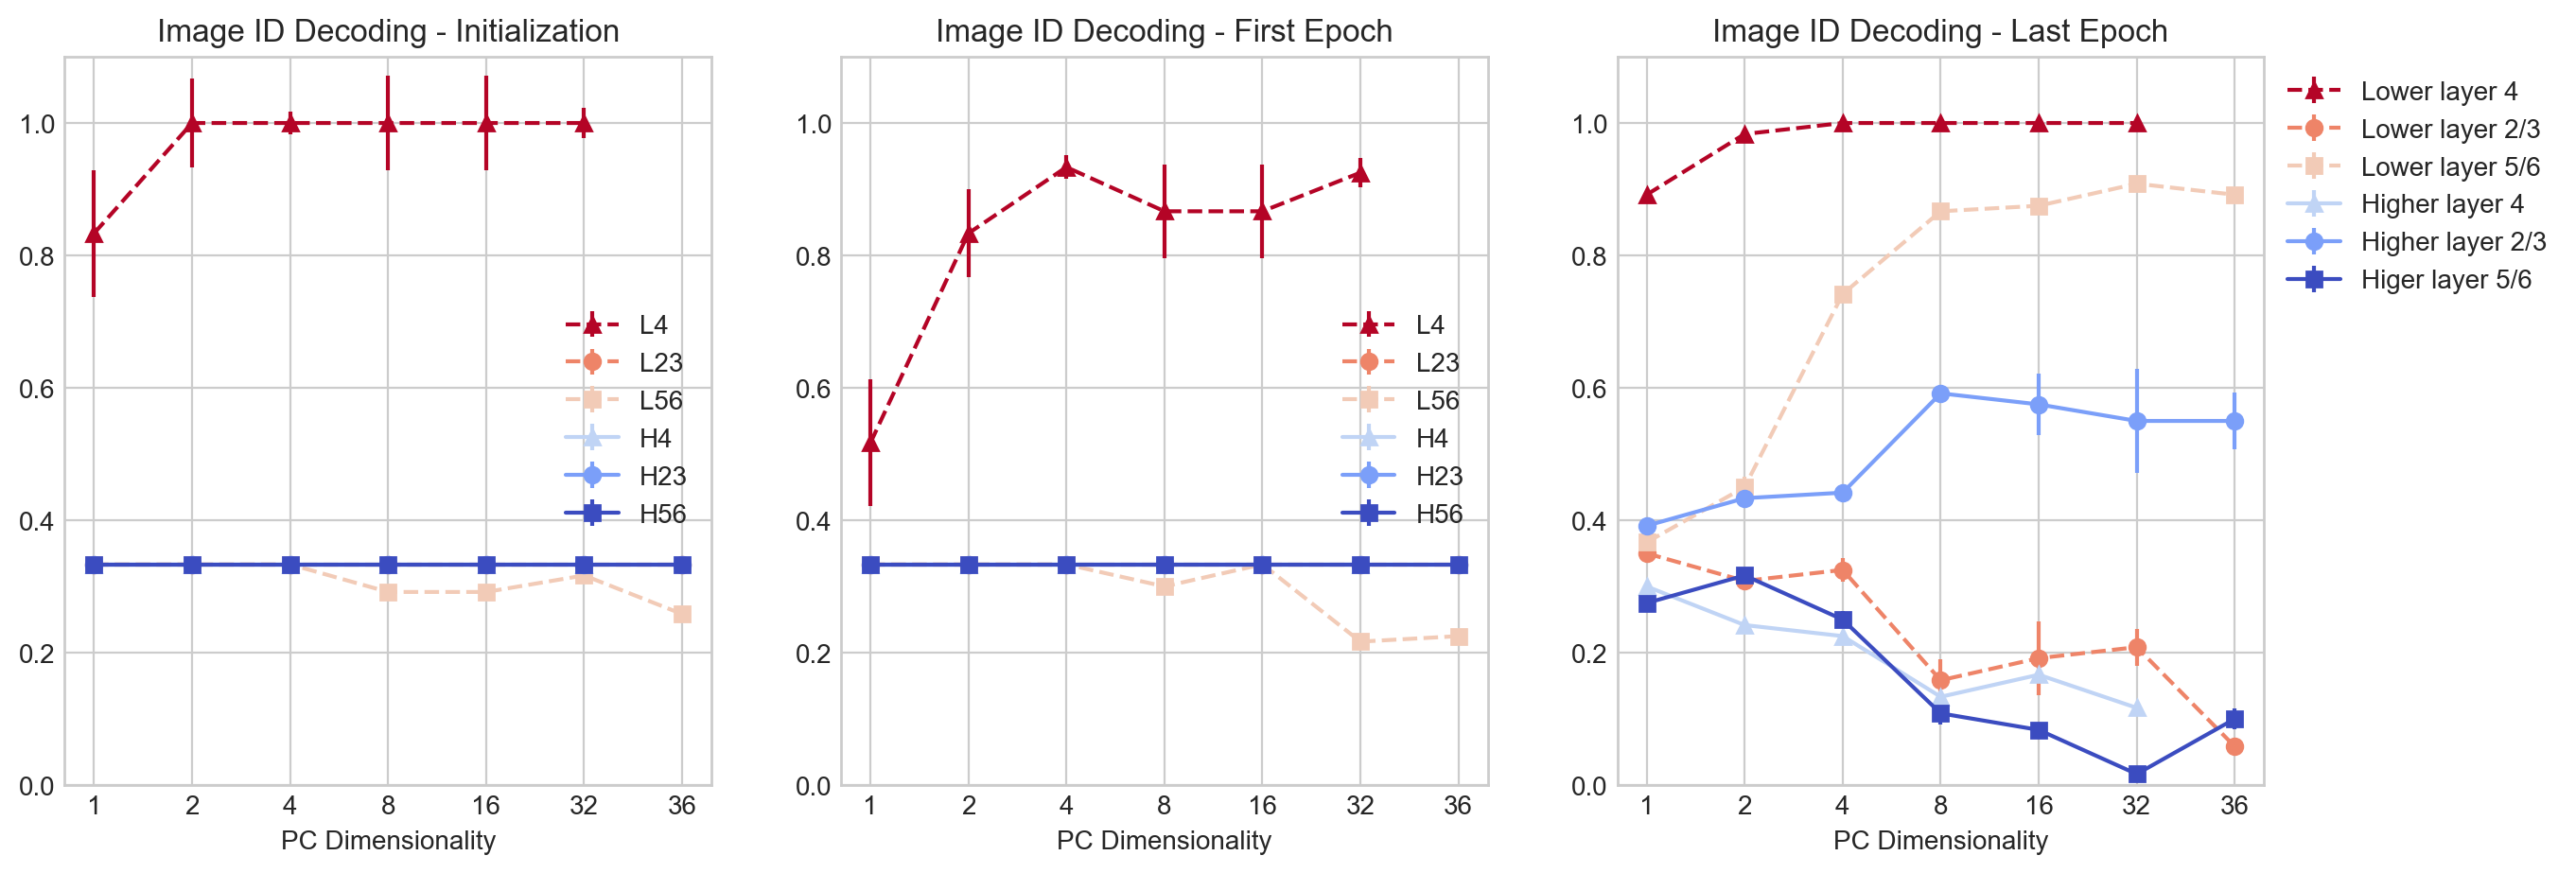

In [128]:
ffdim = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Image ID Decoding - Initialization')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4imgPC[:,0],yerr=std_accs_L4imgPC[:,1],label='L4',fmt='--^',
             color=cols[0])
plt.errorbar(np.arange(len(dims23)),mean_accs_L23imgPC[:,0],yerr=std_accs_L23imgPC[:,1],label='L23',fmt='--o',
             color=cols[1])
plt.errorbar(np.arange(len(dims56)),mean_accs_L56imgPC[:,0],yerr=std_accs_L56imgPC[:,1],label='L56',fmt='--s',
             color=cols[2])
plt.errorbar(np.arange(len(dims4)),mean_accs_H4imgPC[:,0],yerr=std_accs_H4imgPC[:,1],label='H4',fmt='-^',
             color=cols[3])
plt.errorbar(np.arange(len(dims23)),mean_accs_H23imgPC[:,0],yerr=std_accs_H23imgPC[:,1],label='H23',fmt='-o',
             color=cols[4])
plt.errorbar(np.arange(len(dims56)),mean_accs_H56imgPC[:,0],yerr=std_accs_H56imgPC[:,1],label='H56',fmt='-s',
             color=cols[5])
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(132)
plt.title('Image ID Decoding - First Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4imgPC[:,1],yerr=std_accs_L4imgPC[:,1],label='L4',fmt='--^',
             color=cols[0])
plt.errorbar(np.arange(len(dims23)),mean_accs_L23imgPC[:,1],yerr=std_accs_L23imgPC[:,1],label='L23',fmt='--o',
             color=cols[1])
plt.errorbar(np.arange(len(dims56)),mean_accs_L56imgPC[:,1],yerr=std_accs_L56imgPC[:,1],label='L56',fmt='--s',
             color=cols[2])
plt.errorbar(np.arange(len(dims4)),mean_accs_H4imgPC[:,1],yerr=std_accs_H4imgPC[:,1],label='H4',fmt='-^',
             color=cols[3])
plt.errorbar(np.arange(len(dims23)),mean_accs_H23imgPC[:,1],yerr=std_accs_H23imgPC[:,1],label='H23',fmt='-o',
             color=cols[4])
plt.errorbar(np.arange(len(dims56)),mean_accs_H56imgPC[:,1],yerr=std_accs_H56imgPC[:,1],label='H56',fmt='-s',
             color=cols[5])
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(133)
plt.title('Image ID Decoding - Last Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4imgPC[:,-1],yerr=std_accs_L4imgPC[:,-1],label='Lower layer 4',fmt='--^',
             color=cols[0])
plt.errorbar(np.arange(len(dims23)),mean_accs_L23imgPC[:,-1],yerr=std_accs_L23imgPC[:,-1],label='Lower layer 2/3',fmt='--o',
             color=cols[1])
plt.errorbar(np.arange(len(dims56)),mean_accs_L56imgPC[:,-1],yerr=std_accs_L56imgPC[:,-1],label='Lower layer 5/6',fmt='--s',
             color=cols[2])
plt.errorbar(np.arange(len(dims4)),mean_accs_H4imgPC[:,-1],yerr=std_accs_H4imgPC[:,-1],label='Higher layer 4',fmt='-^',
             color=cols[3])
plt.errorbar(np.arange(len(dims23)),mean_accs_H23imgPC[:,-1],yerr=std_accs_H23imgPC[:,-1],label='Higher layer 2/3',fmt='-o',
             color=cols[4])
plt.errorbar(np.arange(len(dims56)),mean_accs_H56imgPC[:,-1],yerr=std_accs_H56imgPC[:,-1],label='Higer layer 5/6',fmt='-s',
             color=cols[5])
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend(bbox_to_anchor=(1,1))

In [129]:
ffdim.savefig('repeated-runs-corticalRNN-no-td-imageID-decoding-across-pcs-V2.png',dpi=300)
ffdim.savefig('repeated-runs-corticalRNN-no-td-imageID-decoding-across-pcs-V2.svg',dpi=300)

Text(0, 0.5, 'Accuracy')

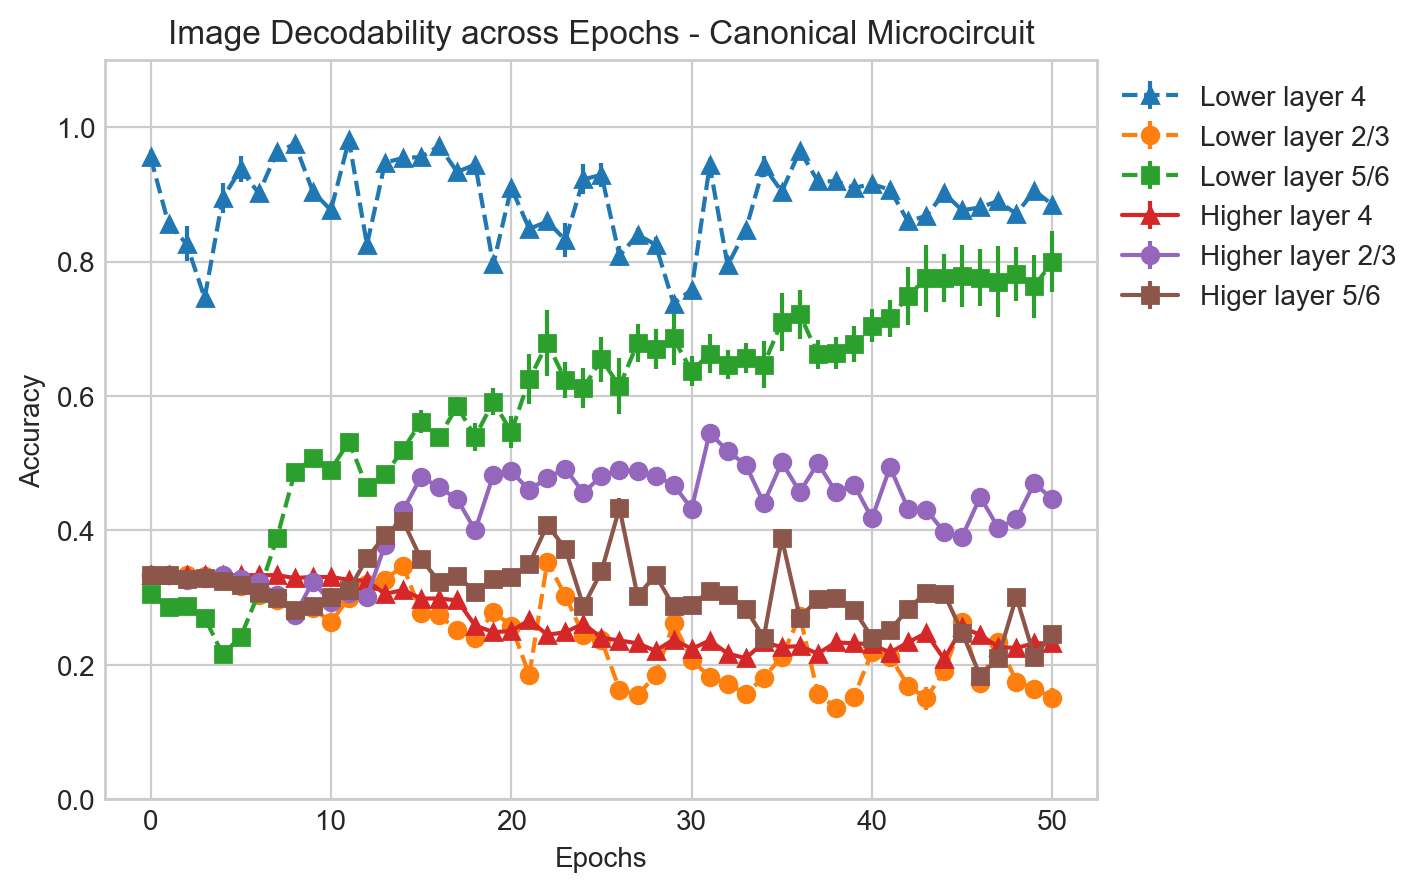

In [110]:
fimg_pcs = plt.figure()
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L4imgPC,0),yerr=np.var(mean_accs_L4imgPC,0),label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L23imgPC,0),yerr=np.var(mean_accs_L23imgPC,0),label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L56imgPC,0),yerr=np.var(mean_accs_L56imgPC,0),label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H4imgPC,0),yerr=np.var(mean_accs_H4imgPC,0),label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H23imgPC,0),yerr=np.var(mean_accs_H23imgPC,0),label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H56imgPC,0),yerr=np.var(mean_accs_H56imgPC,0),label='Higer layer 5/6',fmt='-s')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Image Decodability across Epochs - Canonical Microcircuit')
plt.ylabel('Accuracy')

In [111]:
# ffepoch = plt.figure(figsize=(15,11))

# plt.subplot(231)
# plt.title('Image ID Decoding - 1D')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L4imgPC[0],yerr=std_accs_L4imgPC[0],label='L4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L23imgPC[0],yerr=std_accs_L23imgPC[0],label='L23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L56imgPC[0],yerr=std_accs_L56imgPC[0],label='L56',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H4imgPC[0],yerr=std_accs_H4imgPC[0],label='H4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H23imgPC[0],yerr=std_accs_H23imgPC[0],label='H23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H56imgPC[0],yerr=std_accs_H56imgPC[0],label='H56',fmt='.')
# plt.xlabel('Epochs')
# plt.ylim(0,1.1)
# plt.legend()

# plt.subplot(232)
# plt.title('Image ID Decoding - 2D')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L4imgPC[1],yerr=std_accs_L4imgPC[1],label='L4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L23imgPC[1],yerr=std_accs_L23imgPC[1],label='L23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L56imgPC[1],yerr=std_accs_L56imgPC[1],label='L56',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H4imgPC[1],yerr=std_accs_H4imgPC[1],label='H4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H23imgPC[1],yerr=std_accs_H23imgPC[1],label='H23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H56imgPC[1],yerr=std_accs_H56imgPC[1],label='H56',fmt='.')
# plt.xlabel('Epochs')
# plt.ylim(0,1.1)
# plt.legend()

# plt.subplot(233)
# plt.title('Image ID Decoding - 32D')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L4imgPC[-1],yerr=std_accs_L4imgPC[-1],label='L4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L23imgPC[-1],yerr=std_accs_L23imgPC[-1],label='L23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L56imgPC[-1],yerr=std_accs_L56imgPC[-1],label='L56',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H4imgPC[-1],yerr=std_accs_H4imgPC[-1],label='H4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H23imgPC[-1],yerr=std_accs_H23imgPC[-1],label='H23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H56imgPC[-1],yerr=std_accs_H56imgPC[-1],label='H56',fmt='.')
# plt.xlabel('Epochs')
# plt.ylim(0,1.1)
# plt.legend()

# plt.subplot(234)
# plt.title('Surprise Decoding - 1D')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L4surpPC[0],yerr=std_accs_L4surpPC[0],label='L4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L23surpPC[0],yerr=std_accs_L23surpPC[0],label='L23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L56surpPC[0],yerr=std_accs_L56surpPC[0],label='L56',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H4surpPC[0],yerr=std_accs_H4surpPC[0],label='H4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H23surpPC[0],yerr=std_accs_H23surpPC[0],label='H23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H56surpPC[0],yerr=std_accs_H56surpPC[0],label='H56',fmt='.')
# plt.xlabel('Epochs')
# plt.ylim(0,1.1)
# plt.legend()

# plt.subplot(235)
# plt.title('Surprise Decoding - 2D')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L4surpPC[1],yerr=std_accs_L4surpPC[1],label='L4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L23surpPC[1],yerr=std_accs_L23surpPC[1],label='L23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L56surpPC[1],yerr=std_accs_L56surpPC[1],label='L56',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H4surpPC[1],yerr=std_accs_H4surpPC[1],label='H4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H23surpPC[1],yerr=std_accs_H23surpPC[1],label='H23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H56surpPC[1],yerr=std_accs_H56surpPC[1],label='H56',fmt='.')
# plt.xlabel('Epochs')
# plt.ylim(0,1.1)
# plt.legend()

# plt.subplot(236)
# plt.title('Surprise Decoding - 32D')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L4surpPC[-1],yerr=std_accs_L4surpPC[-1],label='L4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L23surpPC[-1],yerr=std_accs_L23surpPC[-1],label='L23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_L56surpPC[-1],yerr=std_accs_L56surpPC[-1],label='L56',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H4surpPC[-1],yerr=std_accs_H4surpPC[-1],label='H4',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H23surpPC[-1],yerr=std_accs_H23surpPC[-1],label='H23',fmt='.')
# plt.errorbar(np.arange(n_epochs+1),mean_accs_H56surpPC[-1],yerr=std_accs_H56surpPC[-1],label='H56',fmt='.')
# plt.xlabel('Epochs')
# plt.ylim(0,1.1)

# plt.legend()
# plt.show()

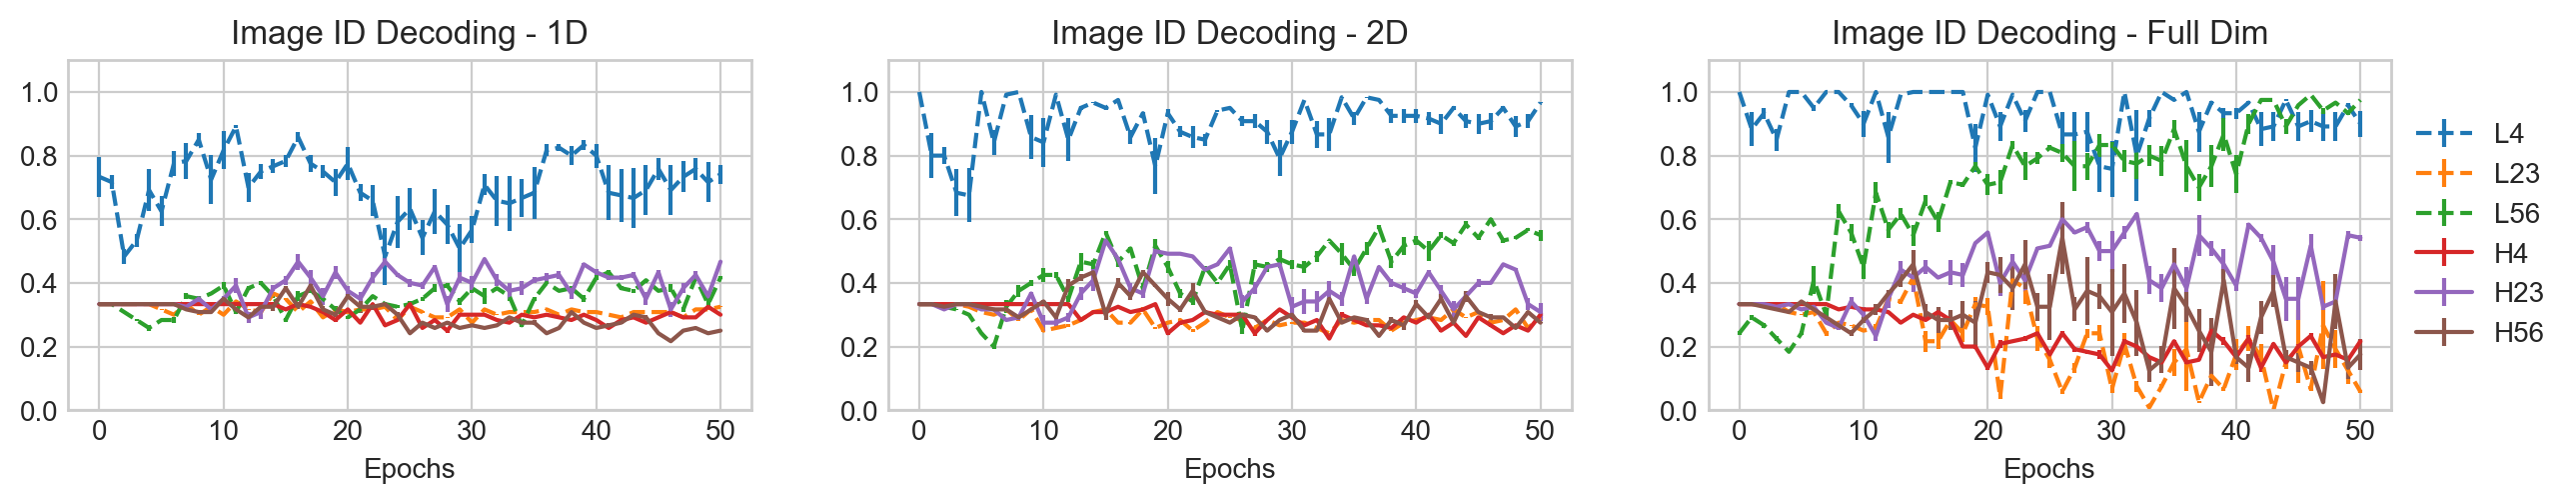

In [112]:
ffepoch = plt.figure(figsize=(15,5))

plt.subplot(231)
plt.title('Image ID Decoding - 1D')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4imgPC[0],yerr=std_accs_L4imgPC[0],label='L4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23imgPC[0],yerr=std_accs_L23imgPC[0],label='L23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56imgPC[0],yerr=std_accs_L56imgPC[0],label='L56',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4imgPC[0],yerr=std_accs_H4imgPC[0],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23imgPC[0],yerr=std_accs_H23imgPC[0],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56imgPC[0],yerr=std_accs_H56imgPC[0],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.subplot(232)
plt.title('Image ID Decoding - 2D')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4imgPC[1],yerr=std_accs_L4imgPC[1],label='L4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23imgPC[1],yerr=std_accs_L23imgPC[1],label='L23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56imgPC[1],yerr=std_accs_L56imgPC[1],label='L56',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4imgPC[1],yerr=std_accs_H4imgPC[1],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23imgPC[1],yerr=std_accs_H23imgPC[1],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56imgPC[1],yerr=std_accs_H56imgPC[1],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.subplot(233)
plt.title('Image ID Decoding - Full Dim')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4imgPC[-1],yerr=std_accs_L4imgPC[-1],label='L4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23imgPC[-1],yerr=std_accs_L23imgPC[-1],label='L23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56imgPC[-1],yerr=std_accs_L56imgPC[-1],label='L56',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4imgPC[-1],yerr=std_accs_H4imgPC[-1],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23imgPC[-1],yerr=std_accs_H23imgPC[-1],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56imgPC[-1],yerr=std_accs_H56imgPC[-1],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [113]:
ffepoch.savefig('repeated-runs-corticalRNN-no-td-imageID-decoding-across-epochs-V2.png',dpi=300)
ffepoch.savefig('repeated-runs-corticalRNN-no-td-imageID-decoding-across-epochs-V2.svg',dpi=300)

#### Position decoding

In [114]:
def repsDecodeSupervisedPosition(rnnActs,labels,clf='svm'):
    nEpochs, nSamps, nNeurons = rnnActs.shape
    decode_dict = {}
    
    nClasses = 6
    
    reps_preds_probs = np.zeros((nEpochs,nSamps,nClasses))
    
    for ep in (range(nEpochs)):
        repsR = rnnActs[ep]
        
        ## Decoding
        if clf=='svm':
            clfR = SVC(kernel='linear',probability=True).fit(repsR,labels)
        elif clf=='logistic':
            clfR = LogisticRegression().fit(repsR,labels)
        elif clf=='perceptron':
            clfR = Perceptron().fit(repsR,labels)
        
        reps_preds_probs[ep] = clfR.predict_proba(repsR)
        decode_dict[str(ep)] = clfR
        
    return reps_preds_probs, decode_dict

In [115]:
L4posPC = {}
L23posPC = {}
L56posPC = {}
H4posPC = {}
H23posPC = {}
H56posPC = {}

In [116]:
for cntr in tqdm(range(nRuns)):
    
    for d in dims23:
        L23posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][1][:,:,:d],labelMtxC[:,-1])
        H23posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][4][:,:,:d],labelMtxC[:,-1])
    
    for d in dims4:
        L4posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][0][:,:,:d],labelMtxC[:,-1])
        H4posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][3][:,:,:d],labelMtxC[:,-1])
        
    for d in dims56:
        ## Position
        L56posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][2][:,:,:d],labelMtxC[:,-1])      
        H56posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][5][:,:,:d],labelMtxC[:,-1])

100%|██████████| 5/5 [00:25<00:00,  5.07s/it]


In [117]:
preds_L23posPC = {}
preds_L4posPC = {}
preds_L56posPC = {}

preds_H23posPC = {}
preds_H4posPC = {}
preds_H56posPC = {}

In [118]:
accs_L23posPC = {}
accs_L4posPC = {}
accs_L56posPC = {}

accs_H23posPC = {}
accs_H4posPC = {}
accs_H56posPC = {}

In [119]:
for cntr in range(nRuns):
    
    for ep in range(n_epochs+1):
        
        for d in dims23:
            preds_L23posPC[cntr,d,ep] = np.argmax(L23posPC[cntr,d][ep],axis=-1)
            preds_H23posPC[cntr,d,ep] = np.argmax(H23posPC[cntr,d][ep],axis=-1)
            
            accs_L23posPC[cntr,d,ep] = accuracy_score(labelMtxC[:,-1],preds_L23posPC[cntr,d,ep])
            accs_H23posPC[cntr,d,ep] = accuracy_score(labelMtxC[:,-1],preds_H23posPC[cntr,d,ep])
            
        for d in dims4:
            preds_L4posPC[cntr,d,ep] = np.argmax(L4posPC[cntr,d][ep],axis=-1)
            preds_H4posPC[cntr,d,ep] = np.argmax(H4posPC[cntr,d][ep],axis=-1)
            
            accs_L4posPC[cntr,d,ep] = accuracy_score(labelMtxC[:,-1],preds_L4posPC[cntr,d,ep])
            accs_H4posPC[cntr,d,ep] = accuracy_score(labelMtxC[:,-1],preds_H4posPC[cntr,d,ep])
            
        for d in dims56:
            preds_L56posPC[cntr,d,ep] = np.argmax(L56posPC[cntr,d][ep],axis=-1)
            preds_H56posPC[cntr,d,ep] = np.argmax(H56posPC[cntr,d][ep],axis=-1)
            
            accs_L56posPC[cntr,d,ep] = accuracy_score(labelMtxC[:,-1],preds_L56posPC[cntr,d,ep])
            accs_H56posPC[cntr,d,ep] = accuracy_score(labelMtxC[:,-1],preds_H56posPC[cntr,d,ep])

In [120]:
tensor_accs_L23posPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_L4posPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_L56posPC = np.zeros((nRuns,len(dims56),n_epochs+1))

tensor_accs_H23posPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_H4posPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_H56posPC = np.zeros((nRuns,len(dims56),n_epochs+1))

In [121]:
for ii in range(nRuns):
    
    for kk in range(n_epochs+1):
        
        for jj,d in enumerate(dims23):
            tensor_accs_L23posPC[ii,jj,kk] = accs_L23posPC[ii,d,kk]
            tensor_accs_H23posPC[ii,jj,kk] = accs_H23posPC[ii,d,kk]
            
        for jj,d in enumerate(dims4):
            tensor_accs_L4posPC[ii,jj,kk] = accs_L4posPC[ii,d,kk]
            tensor_accs_H4posPC[ii,jj,kk] = accs_H4posPC[ii,d,kk]
            
        for jj,d in enumerate(dims56):            
            tensor_accs_L56posPC[ii,jj,kk] = accs_L56posPC[ii,d,kk]            
            tensor_accs_H56posPC[ii,jj,kk] = accs_H56posPC[ii,d,kk]

In [122]:
mean_accs_L4posPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_L23posPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_L56posPC = np.zeros((len(dims56),n_epochs+1))

mean_accs_H4posPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_H23posPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_H56posPC = np.zeros((len(dims56),n_epochs+1))

std_accs_L4posPC = np.zeros((len(dims4),n_epochs+1))
std_accs_L23posPC = np.zeros((len(dims23),n_epochs+1))
std_accs_L56posPC = np.zeros((len(dims56),n_epochs+1))

std_accs_H4posPC = np.zeros((len(dims4),n_epochs+1))
std_accs_H23posPC = np.zeros((len(dims23),n_epochs+1))
std_accs_H56posPC = np.zeros((len(dims56),n_epochs+1))

In [123]:
for ep in range(n_epochs+1):
    
    for dd, dim in enumerate(dims23):
        mean_accs_L23posPC[dd,ep] = np.mean(tensor_accs_L23posPC[:,dd,ep])
        mean_accs_H23posPC[dd,ep] = np.mean(tensor_accs_H23posPC[:,dd,ep])
        
        std_accs_L23posPC[dd,ep] = np.var(tensor_accs_L23posPC[:,dd,ep])
        std_accs_H23posPC[dd,ep] = np.var(tensor_accs_H23posPC[:,dd,ep])
        
    for dd, dim in enumerate(dims4):
        mean_accs_L4posPC[dd,ep] = np.mean(tensor_accs_L4posPC[:,dd,ep])
        mean_accs_H4posPC[dd,ep] = np.mean(tensor_accs_H4posPC[:,dd,ep])
        
        std_accs_L4posPC[dd,ep] = np.var(tensor_accs_L4posPC[:,dd,ep])
        std_accs_H4posPC[dd,ep] = np.var(tensor_accs_H4posPC[:,dd,ep])
        
    for dd, dim in enumerate(dims56):
        mean_accs_L56posPC[dd,ep] = np.mean(tensor_accs_L56posPC[:,dd,ep])
        mean_accs_H56posPC[dd,ep] = np.mean(tensor_accs_H56posPC[:,dd,ep])
        
        std_accs_L56posPC[dd,ep] = np.var(tensor_accs_L56posPC[:,dd,ep])
        std_accs_H56posPC[dd,ep] = np.var(tensor_accs_H56posPC[:,dd,ep])

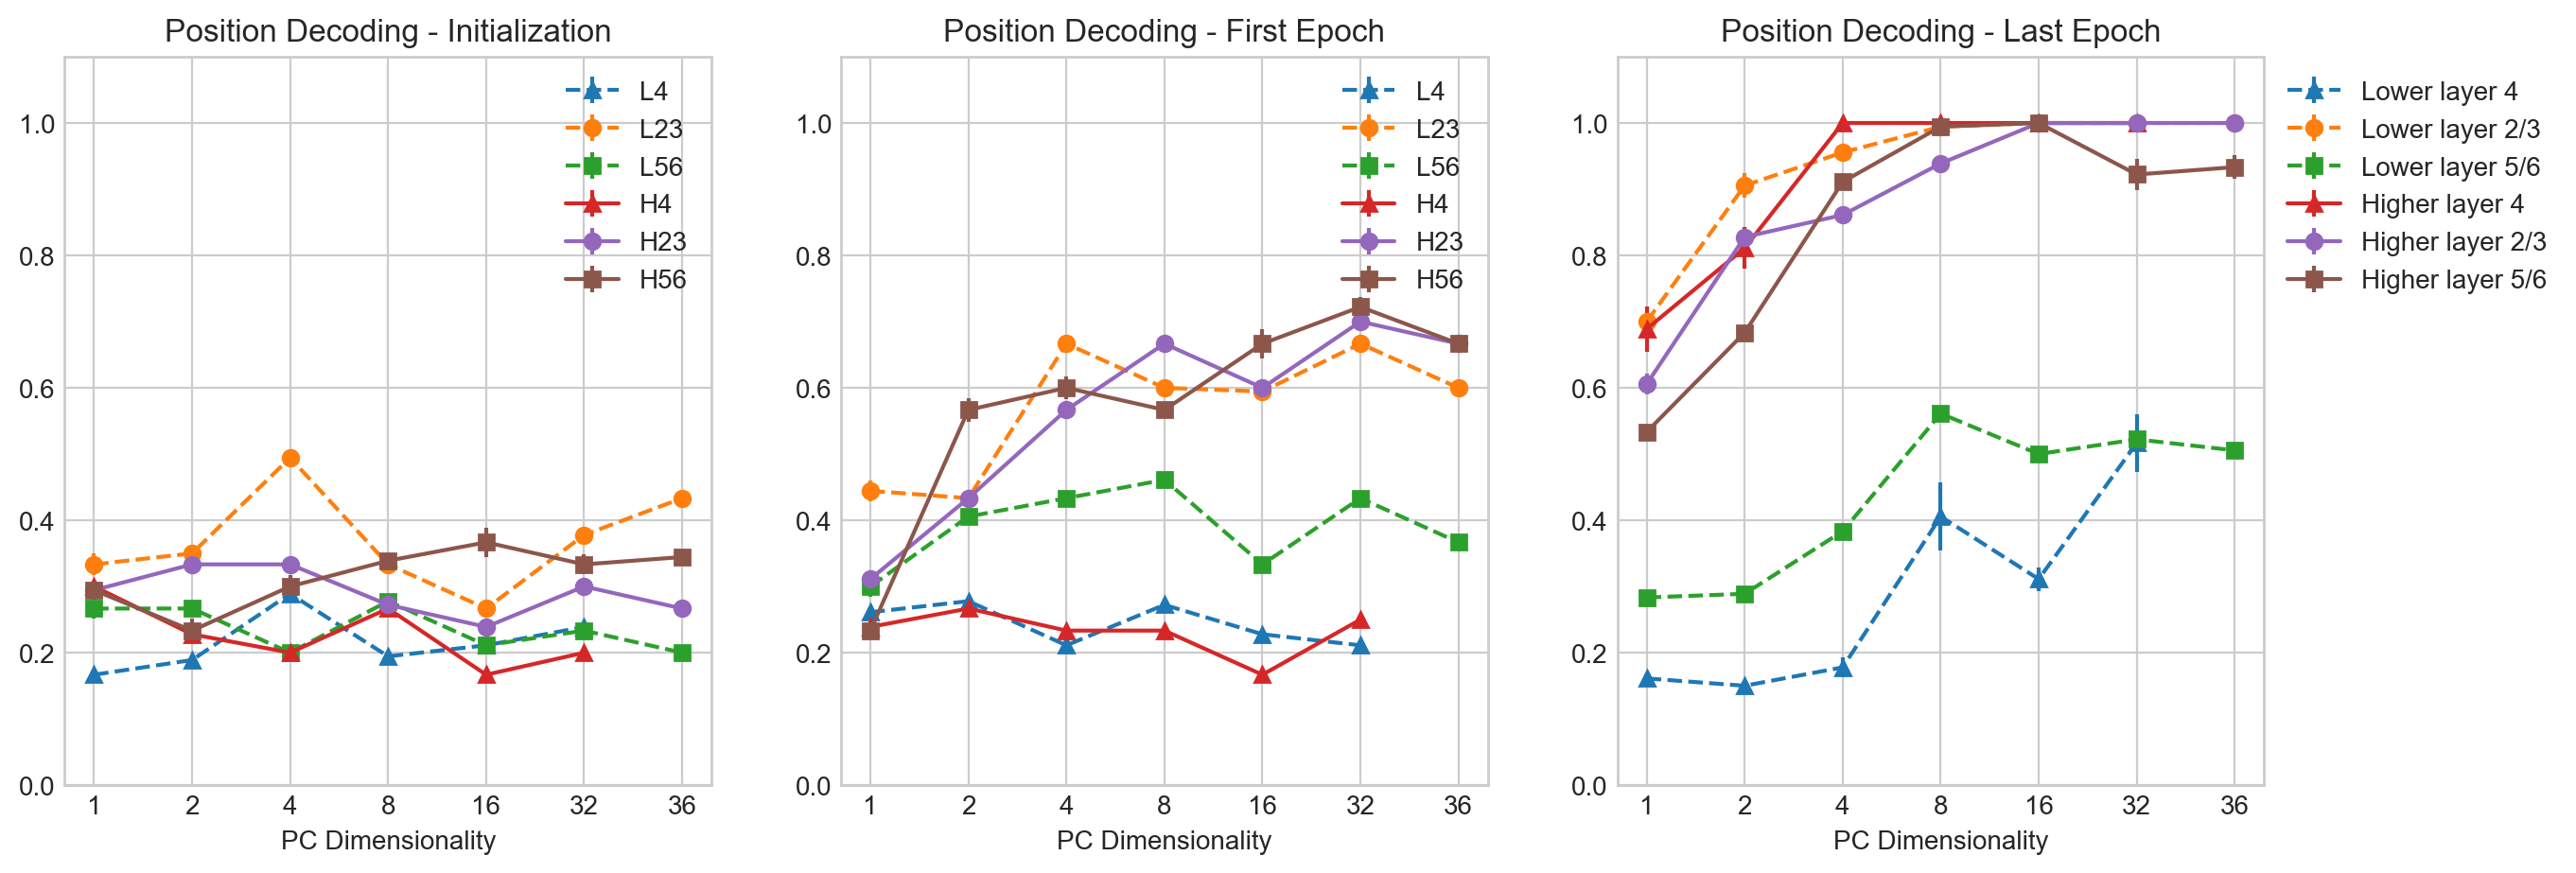

In [124]:
ffpos = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Position Decoding - Initialization')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4posPC[:,0],yerr=std_accs_L4posPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23posPC[:,0],yerr=std_accs_L23posPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56posPC[:,0],yerr=std_accs_L56posPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4posPC[:,0],yerr=std_accs_H4posPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23posPC[:,0],yerr=std_accs_H23posPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56posPC[:,0],yerr=std_accs_H56posPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(132)
plt.title('Position Decoding - First Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4posPC[:,1],yerr=std_accs_L4posPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23posPC[:,1],yerr=std_accs_L23posPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56posPC[:,1],yerr=std_accs_L56posPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4posPC[:,1],yerr=std_accs_H4posPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23posPC[:,1],yerr=std_accs_H23posPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56posPC[:,1],yerr=std_accs_H56posPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(133)
plt.title('Position Decoding - Last Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4posPC[:,-1],yerr=std_accs_L4posPC[:,-1],label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23posPC[:,-1],yerr=std_accs_L23posPC[:,-1],label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56posPC[:,-1],yerr=std_accs_L56posPC[:,-1],label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4posPC[:,-1],yerr=std_accs_H4posPC[:,-1],label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23posPC[:,-1],yerr=std_accs_H23posPC[:,-1],label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56posPC[:,-1],yerr=std_accs_H56posPC[:,-1],label='Higher layer 5/6',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend(bbox_to_anchor=(1,1))

In [125]:
ffpos.savefig('repeated-runs-corticalRNN-no-td-position-decoding-across-pcs-V2.png',dpi=300)
ffpos.savefig('repeated-runs-corticalRNN-no-td-position-decoding-across-pcs-V2.svg',dpi=300)

Text(0, 0.5, 'Accuracy')

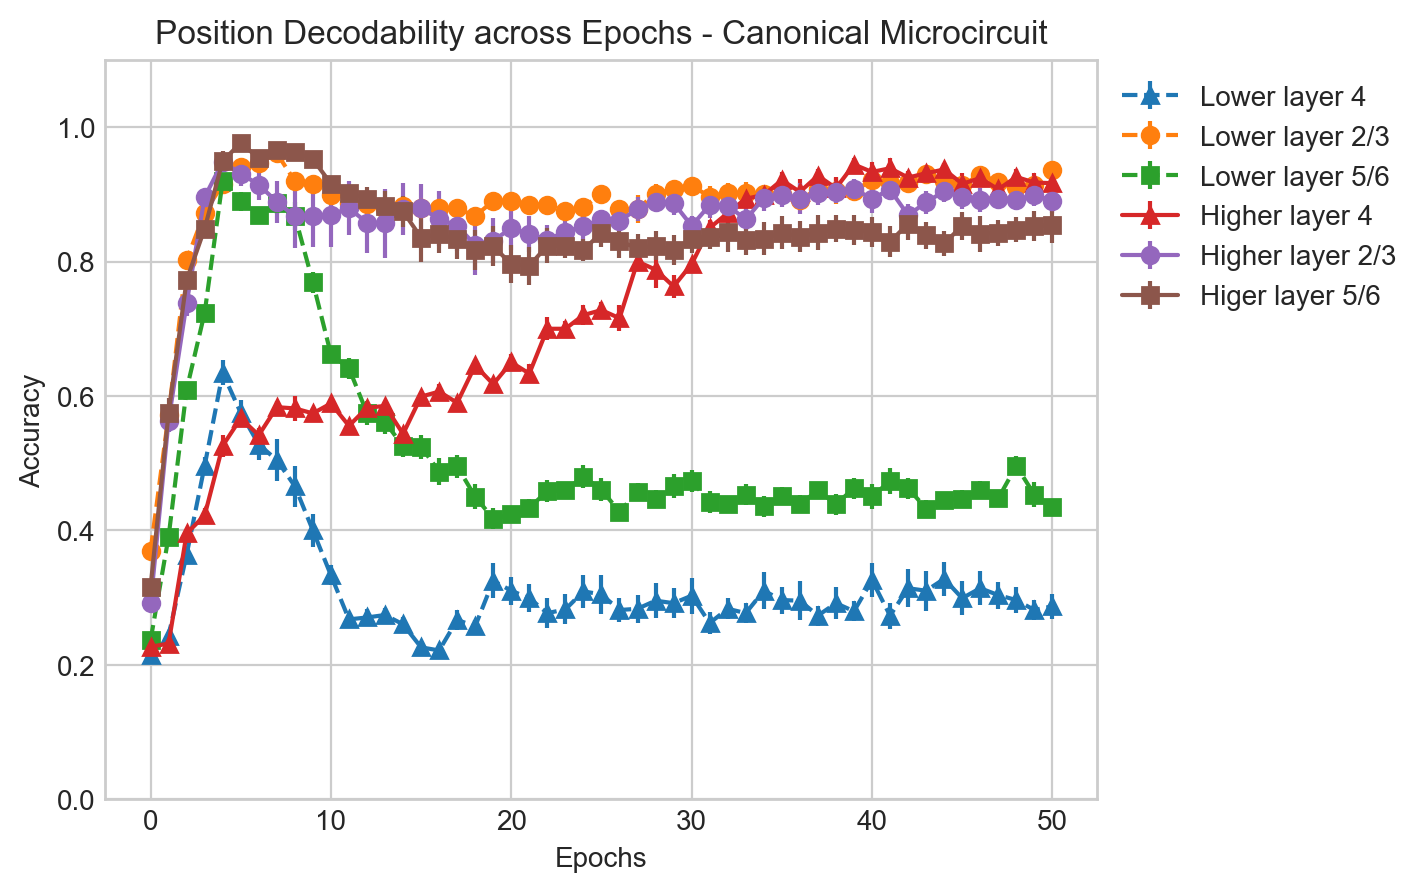

In [126]:
fpos_pcs = plt.figure()
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L4posPC,0),yerr=np.var(mean_accs_L4posPC,0),label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L23posPC,0),yerr=np.var(mean_accs_L23posPC,0),label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L56posPC,0),yerr=np.var(mean_accs_L56posPC,0),label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H4posPC,0),yerr=np.var(mean_accs_H4posPC,0),label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H23posPC,0),yerr=np.var(mean_accs_H23posPC,0),label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H56posPC,0),yerr=np.var(mean_accs_H56posPC,0),label='Higer layer 5/6',fmt='-s')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Position Decodability across Epochs - Canonical Microcircuit')
plt.ylabel('Accuracy')

In [127]:
fpos_pcs.savefig('position-across-epochs-averaged-PCs-corticalRNN-no-td-V2.png',dpi=300,bbox_inches="tight")
fpos_pcs.savefig('position-across-epochs-averaged-PCs-corticalRNN-no-td-V2.svg',dpi=300,bbox_inches="tight")

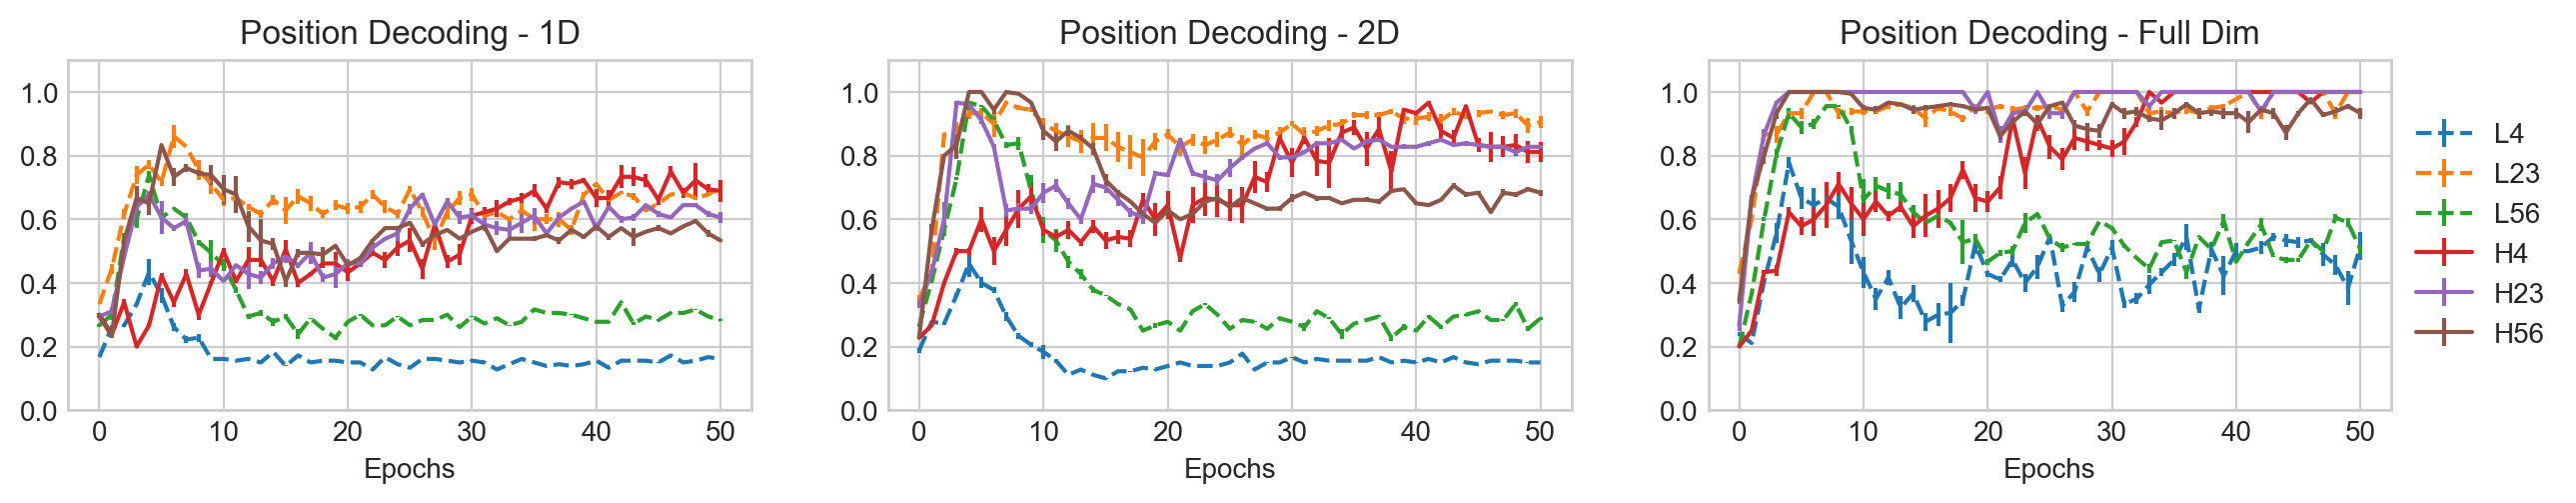

In [128]:
ffpos_epoch = plt.figure(figsize=(15,5))

plt.subplot(231)
plt.title('Position Decoding - 1D')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4posPC[0],yerr=std_accs_L4posPC[0],label='L4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23posPC[0],yerr=std_accs_L23posPC[0],label='L23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56posPC[0],yerr=std_accs_L56posPC[0],label='L56',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4posPC[0],yerr=std_accs_H4posPC[0],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23posPC[0],yerr=std_accs_H23posPC[0],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56posPC[0],yerr=std_accs_H56posPC[0],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.subplot(232)
plt.title('Position Decoding - 2D')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4posPC[1],yerr=std_accs_L4posPC[1],label='L4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23posPC[1],yerr=std_accs_L23posPC[1],label='L23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56posPC[1],yerr=std_accs_L56posPC[1],label='L56',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4posPC[1],yerr=std_accs_H4posPC[1],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23posPC[1],yerr=std_accs_H23posPC[1],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56posPC[1],yerr=std_accs_H56posPC[1],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.subplot(233)
plt.title('Position Decoding - Full Dim')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4posPC[-1],yerr=std_accs_L4posPC[-1],label='L4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23posPC[-1],yerr=std_accs_L23posPC[-1],label='L23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56posPC[-1],yerr=std_accs_L56posPC[-1],label='L56',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4posPC[-1],yerr=std_accs_H4posPC[-1],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23posPC[-1],yerr=std_accs_H23posPC[-1],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56posPC[-1],yerr=std_accs_H56posPC[-1],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [129]:
ffpos_epoch.savefig('repeated-runs-corticalRNN-no-td-position-decoding-across-epochs-V2.png',dpi=300)
ffpos_epoch.savefig('repeated-runs-corticalRNN-no-td-position-decoding-across-epochs-V2.svg',dpi=300)

#### Surprise decoding

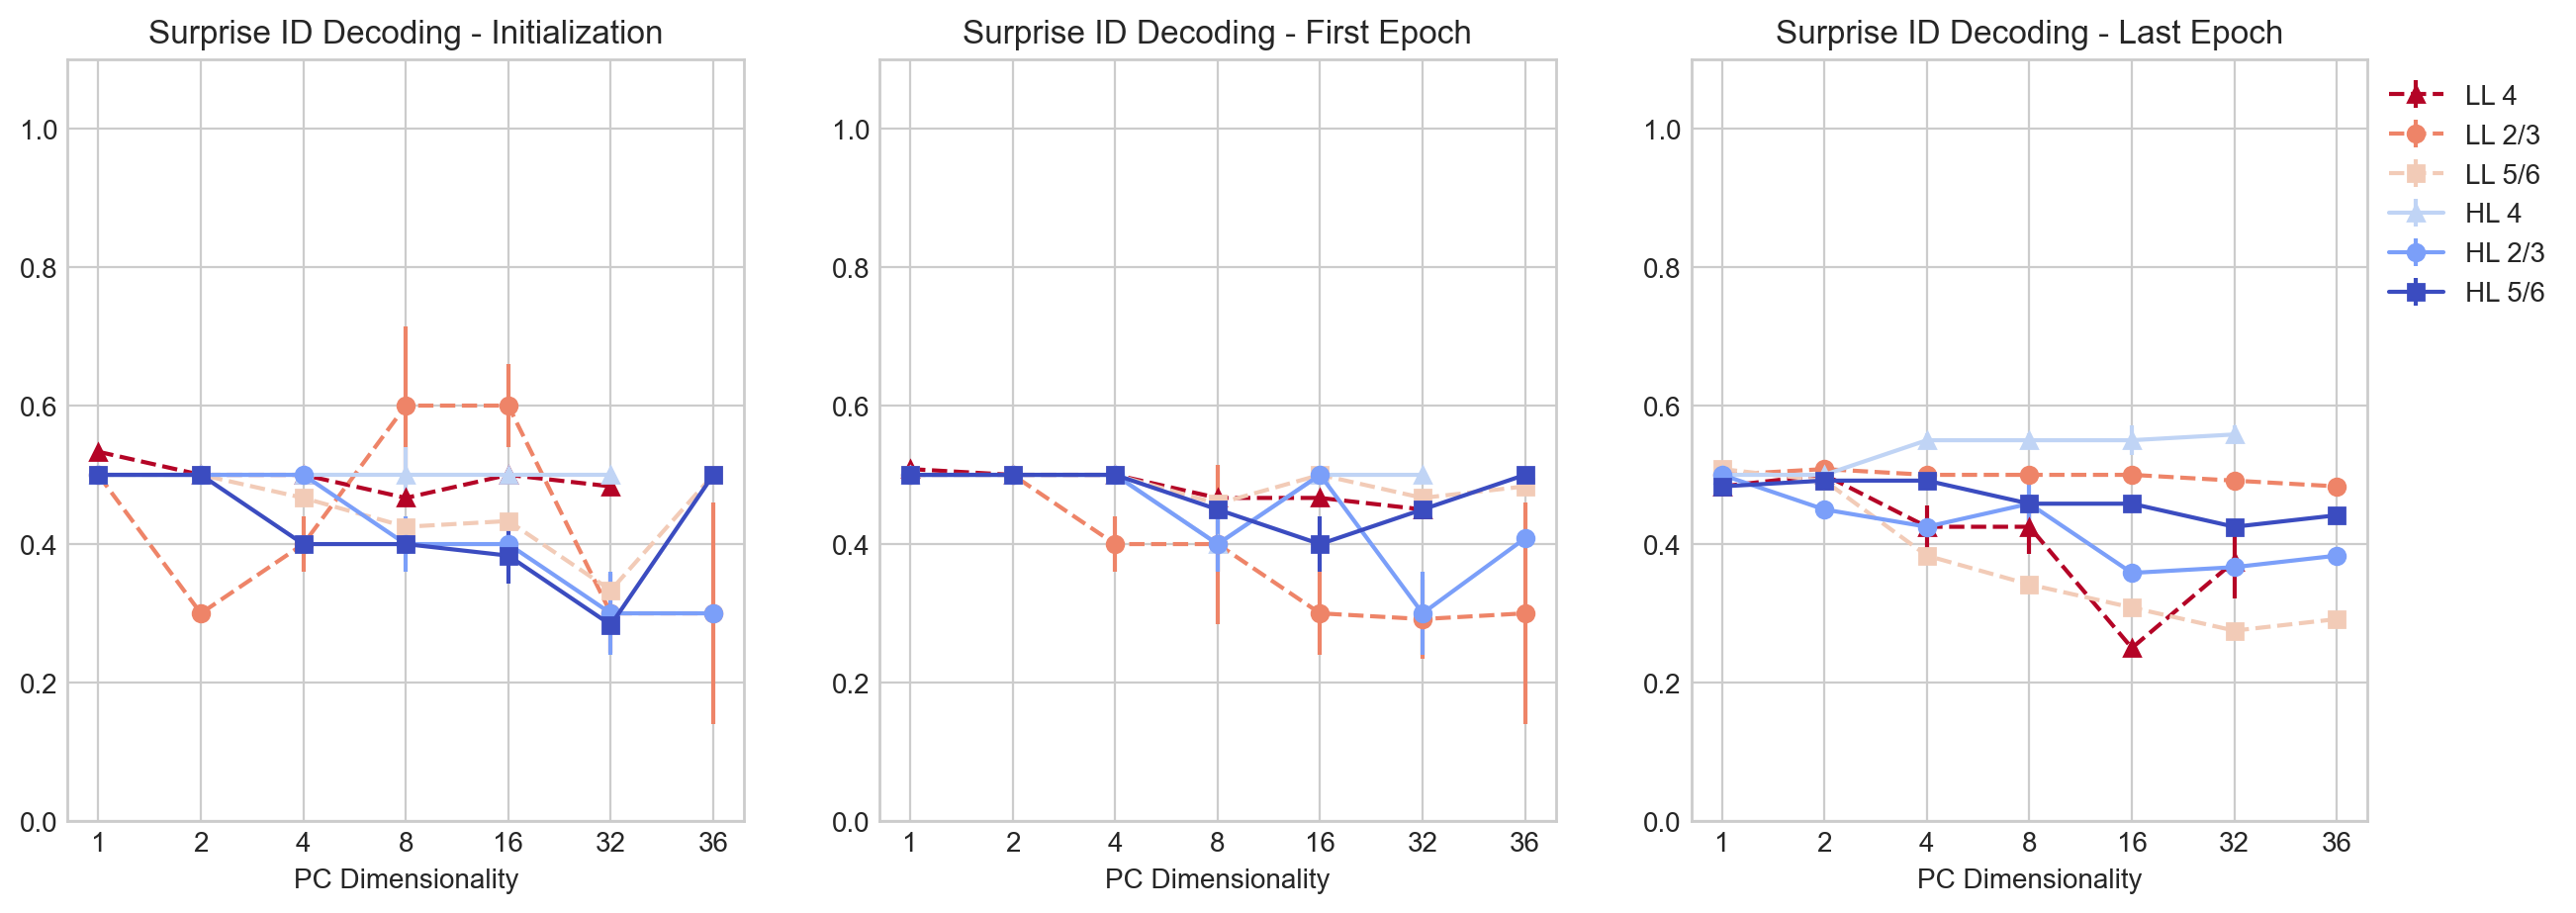

In [138]:
ffsurp_dim = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Surprise ID Decoding - Initialization')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4surpPC[:,0],yerr=std_accs_L4surpPC[:,1],label='L4',fmt='--^',
             color=cols[0])
plt.errorbar(np.arange(len(dims23)),mean_accs_L23surpPC[:,0],yerr=std_accs_L23surpPC[:,1],label='L23',fmt='--o',
             color=cols[1])
plt.errorbar(np.arange(len(dims56)),mean_accs_L56surpPC[:,0],yerr=std_accs_L56surpPC[:,1],label='L56',fmt='--s',
             color=cols[2])
plt.errorbar(np.arange(len(dims4)),mean_accs_H4surpPC[:,0],yerr=std_accs_H4surpPC[:,1],label='H4',fmt='-^',
             color=cols[3])
plt.errorbar(np.arange(len(dims23)),mean_accs_H23surpPC[:,0],yerr=std_accs_H23surpPC[:,1],label='H23',fmt='-o',
             color=cols[4])
plt.errorbar(np.arange(len(dims56)),mean_accs_H56surpPC[:,0],yerr=std_accs_H56surpPC[:,1],label='H56',fmt='-s',
             color=cols[5])
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
# plt.legend()

plt.subplot(132)
plt.title('Surprise ID Decoding - First Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4surpPC[:,1],yerr=std_accs_L4surpPC[:,1],label='L4',fmt='--^',
             color=cols[0])
plt.errorbar(np.arange(len(dims23)),mean_accs_L23surpPC[:,1],yerr=std_accs_L23surpPC[:,1],label='L23',fmt='--o',
             color=cols[1])
plt.errorbar(np.arange(len(dims56)),mean_accs_L56surpPC[:,1],yerr=std_accs_L56surpPC[:,1],label='L56',fmt='--s',
             color=cols[2])
plt.errorbar(np.arange(len(dims4)),mean_accs_H4surpPC[:,1],yerr=std_accs_H4surpPC[:,1],label='H4',fmt='-^',
             color=cols[3])
plt.errorbar(np.arange(len(dims23)),mean_accs_H23surpPC[:,1],yerr=std_accs_H23surpPC[:,1],label='H23',fmt='-o',
             color=cols[4])
plt.errorbar(np.arange(len(dims56)),mean_accs_H56surpPC[:,1],yerr=std_accs_H56surpPC[:,1],label='H56',fmt='-s',
             color=cols[5])
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
# plt.legend()

plt.subplot(133)
plt.title('Surprise ID Decoding - Last Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4surpPC[:,-1],yerr=std_accs_L4surpPC[:,-1],label='LL 4',fmt='--^',
             color=cols[0])
plt.errorbar(np.arange(len(dims23)),mean_accs_L23surpPC[:,-1],yerr=std_accs_L23surpPC[:,-1],label='LL 2/3',fmt='--o',
             color=cols[1])
plt.errorbar(np.arange(len(dims56)),mean_accs_L56surpPC[:,-1],yerr=std_accs_L56surpPC[:,-1],label='LL 5/6',fmt='--s',
             color=cols[2])
plt.errorbar(np.arange(len(dims4)),mean_accs_H4surpPC[:,-1],yerr=std_accs_H4surpPC[:,-1],label='HL 4',fmt='-^',
             color=cols[3])
plt.errorbar(np.arange(len(dims23)),mean_accs_H23surpPC[:,-1],yerr=std_accs_H23surpPC[:,-1],label='HL 2/3',fmt='-o',
             color=cols[4])
plt.errorbar(np.arange(len(dims56)),mean_accs_H56surpPC[:,-1],yerr=std_accs_H56surpPC[:,-1],label='HL 5/6',fmt='-s',
             color=cols[5])
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend(bbox_to_anchor=(1.3,1))

In [ ]:
# ffsurp_dim = plt.figure(figsize=(15,5))

# plt.subplot(131)
# plt.title('Surprise ID Decoding - Initialization')
# plt.errorbar(np.arange(len(dims4)),mean_accs_L4surpPC[:,0],yerr=std_accs_L4surpPC[:,1],label='L4',fmt='--^')
# plt.errorbar(np.arange(len(dims23)),mean_accs_L23surpPC[:,0],yerr=std_accs_L23surpPC[:,1],label='L23',fmt='--o')
# plt.errorbar(np.arange(len(dims56)),mean_accs_L56surpPC[:,0],yerr=std_accs_L56surpPC[:,1],label='L56',fmt='--s')
# plt.errorbar(np.arange(len(dims4)),mean_accs_H4surpPC[:,0],yerr=std_accs_H4surpPC[:,1],label='H4',fmt='-^')
# plt.errorbar(np.arange(len(dims23)),mean_accs_H23surpPC[:,0],yerr=std_accs_H23surpPC[:,1],label='H23',fmt='-o')
# plt.errorbar(np.arange(len(dims56)),mean_accs_H56surpPC[:,0],yerr=std_accs_H56surpPC[:,1],label='H56',fmt='-s')
# plt.xlabel('PC Dimensionality')
# plt.ylim(0,1.1)
# plt.xticks(np.arange(len(dims23)),dims23)
# # plt.legend()

# plt.subplot(132)
# plt.title('Surprise ID Decoding - First Epoch')
# plt.errorbar(np.arange(len(dims4)),mean_accs_L4surpPC[:,1],yerr=std_accs_L4surpPC[:,1],label='L4',fmt='--^')
# plt.errorbar(np.arange(len(dims23)),mean_accs_L23surpPC[:,1],yerr=std_accs_L23surpPC[:,1],label='L23',fmt='--o')
# plt.errorbar(np.arange(len(dims56)),mean_accs_L56surpPC[:,1],yerr=std_accs_L56surpPC[:,1],label='L56',fmt='--s')
# plt.errorbar(np.arange(len(dims4)),mean_accs_H4surpPC[:,1],yerr=std_accs_H4surpPC[:,1],label='H4',fmt='-^')
# plt.errorbar(np.arange(len(dims23)),mean_accs_H23surpPC[:,1],yerr=std_accs_H23surpPC[:,1],label='H23',fmt='-o')
# plt.errorbar(np.arange(len(dims56)),mean_accs_H56surpPC[:,1],yerr=std_accs_H56surpPC[:,1],label='H56',fmt='-s')
# plt.xlabel('PC Dimensionality')
# plt.ylim(0,1.1)
# plt.xticks(np.arange(len(dims23)),dims23)
# # plt.legend()

# plt.subplot(133)
# plt.title('Surprise ID Decoding - Last Epoch')
# plt.errorbar(np.arange(len(dims4)),mean_accs_L4surpPC[:,-1],yerr=std_accs_L4surpPC[:,-1],label='Lower layer 4',fmt='--^')
# plt.errorbar(np.arange(len(dims23)),mean_accs_L23surpPC[:,-1],yerr=std_accs_L23surpPC[:,-1],label='Lower layer 2/3',fmt='--o')
# plt.errorbar(np.arange(len(dims56)),mean_accs_L56surpPC[:,-1],yerr=std_accs_L56surpPC[:,-1],label='Lower layer 5/6',fmt='--s')
# plt.errorbar(np.arange(len(dims4)),mean_accs_H4surpPC[:,-1],yerr=std_accs_H4surpPC[:,-1],label='Higher layer 4',fmt='-^')
# plt.errorbar(np.arange(len(dims23)),mean_accs_H23surpPC[:,-1],yerr=std_accs_H23surpPC[:,-1],label='Higher layer 2/3',fmt='-o')
# plt.errorbar(np.arange(len(dims56)),mean_accs_H56surpPC[:,-1],yerr=std_accs_H56surpPC[:,-1],label='Higer layer 5/6',fmt='-s')
# plt.xlabel('PC Dimensionality')
# plt.ylim(0,1.1)
# plt.xticks(np.arange(len(dims23)),dims23)
# plt.legend(bbox_to_anchor=(1,1))

In [139]:
ffsurp_dim.savefig('repeated-runs-corticalRNN-no-td-surprise-decoding-across-PCs-V2.png',dpi=300)
ffsurp_dim.savefig('repeated-runs-corticalRNN-no-td-surprise-decoding-across-PCs-V2.svg',dpi=300)

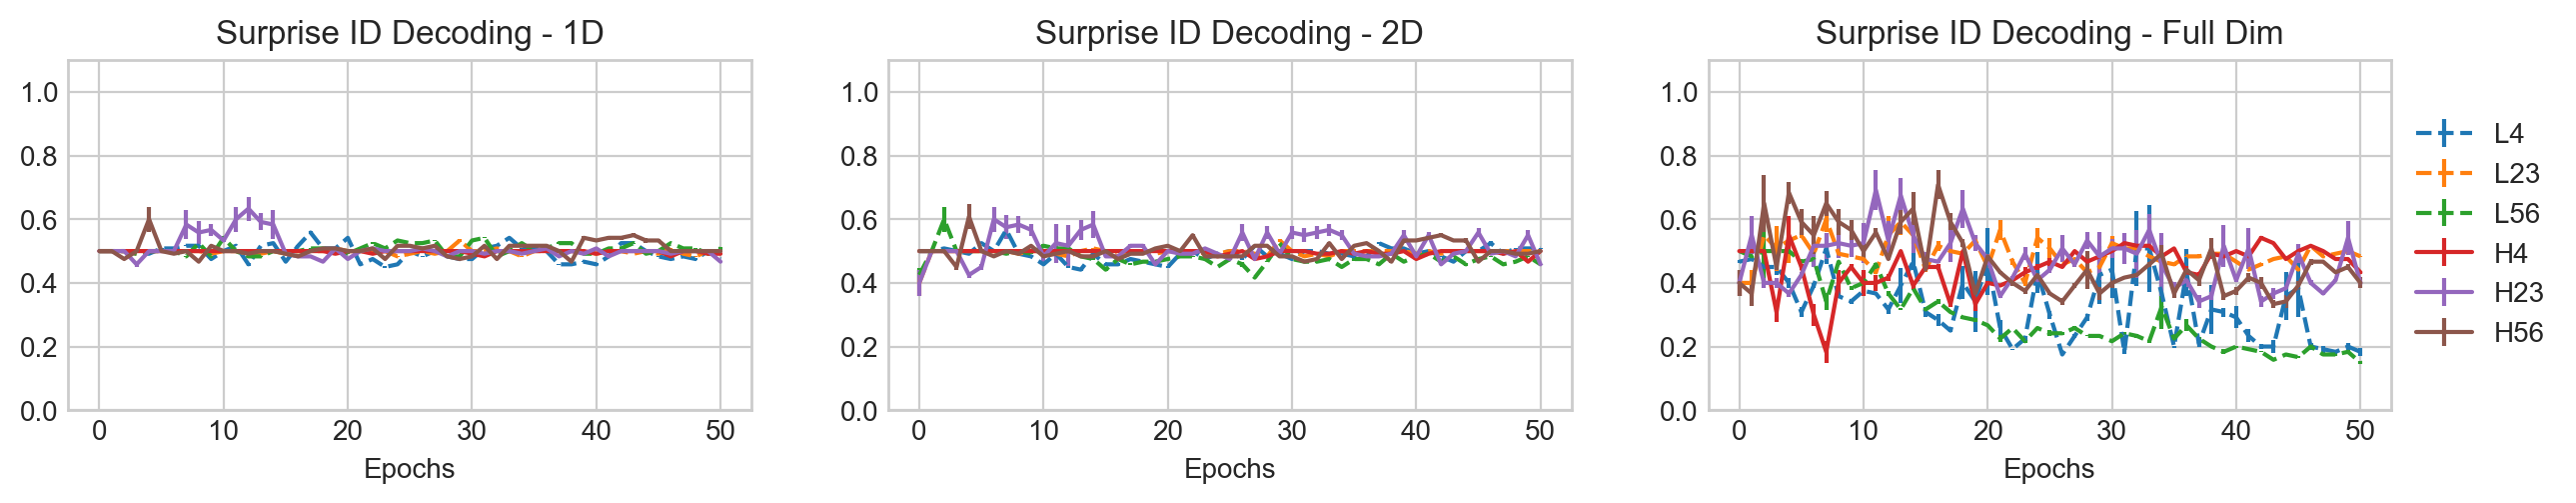

In [132]:
ffsurp_epoch = plt.figure(figsize=(15,5))

plt.subplot(231)
plt.title('Surprise ID Decoding - 1D')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4surpPC[0],yerr=std_accs_L4surpPC[0],label='L4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23surpPC[0],yerr=std_accs_L23surpPC[0],label='L23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56surpPC[0],yerr=std_accs_L56surpPC[0],label='L56',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4surpPC[0],yerr=std_accs_H4surpPC[0],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23surpPC[0],yerr=std_accs_H23surpPC[0],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56surpPC[0],yerr=std_accs_H56surpPC[0],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.subplot(232)
plt.title('Surprise ID Decoding - 2D')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4surpPC[1],yerr=std_accs_L4surpPC[1],label='L4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23surpPC[1],yerr=std_accs_L23surpPC[1],label='L23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56surpPC[1],yerr=std_accs_L56surpPC[1],label='L56',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4surpPC[1],yerr=std_accs_H4surpPC[1],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23surpPC[1],yerr=std_accs_H23surpPC[1],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56surpPC[1],yerr=std_accs_H56surpPC[1],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.subplot(233)
plt.title('Surprise ID Decoding - Full Dim')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4surpPC[-1],yerr=std_accs_L4surpPC[-1],label='L4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23surpPC[-1],yerr=std_accs_L23surpPC[-1],label='L23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56surpPC[-1],yerr=std_accs_L56surpPC[-1],label='L56',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4surpPC[-1],yerr=std_accs_H4surpPC[-1],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23surpPC[-1],yerr=std_accs_H23surpPC[-1],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56surpPC[-1],yerr=std_accs_H56surpPC[-1],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [133]:
ffsurp_epoch.savefig('repeated-runs-corticalRNN-no-td-surprise-decoding-across-epochs-V2.png',dpi=300)
ffsurp_epoch.savefig('repeated-runs-corticalRNN-no-td-surprise-decoding-across-epochs-V2.svg',dpi=300)

Text(0, 0.5, 'Accuracy')

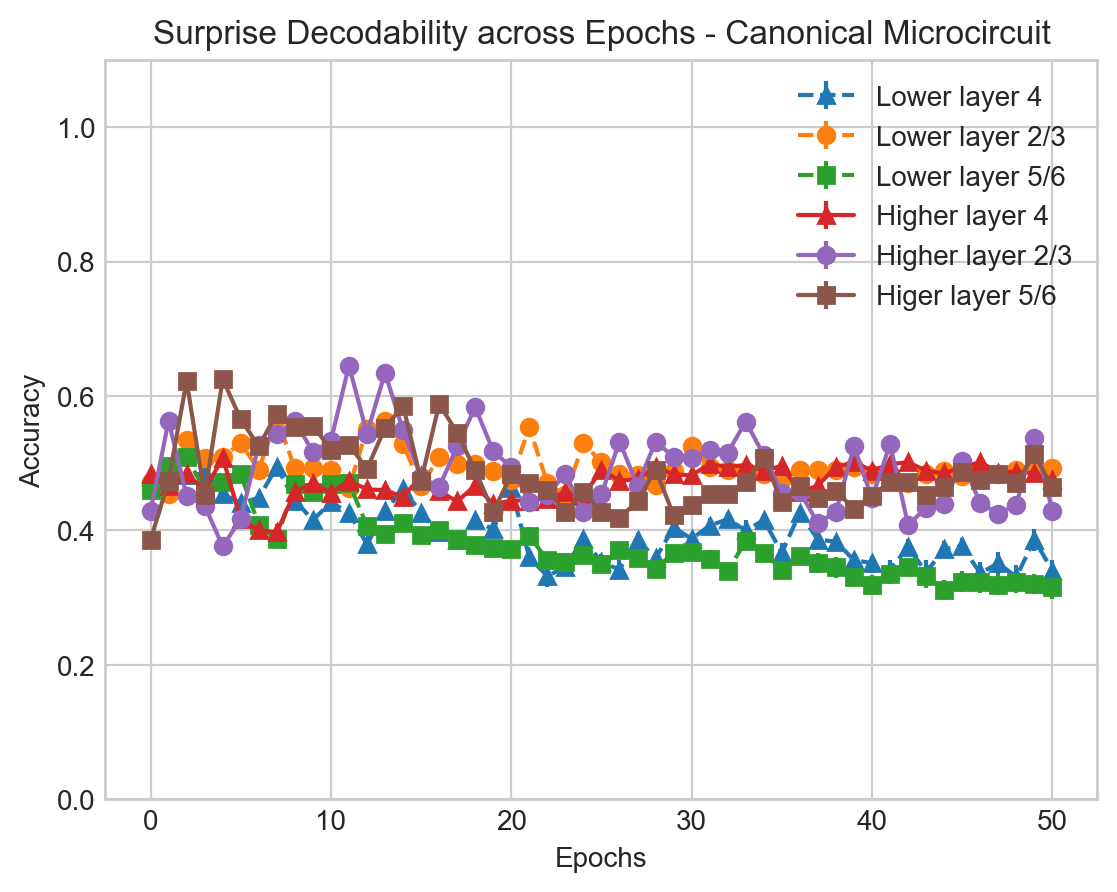

In [134]:
fsurp_pcs = plt.figure()
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L4surpPC,0),yerr=np.var(mean_accs_L4surpPC,0),label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L23surpPC,0),yerr=np.var(mean_accs_L23surpPC,0),label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L56surpPC,0),yerr=np.var(mean_accs_L56surpPC,0),label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H4surpPC,0),yerr=np.var(mean_accs_H4surpPC,0),label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H23surpPC,0),yerr=np.var(mean_accs_H23surpPC,0),label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H56surpPC,0),yerr=np.var(mean_accs_H56surpPC,0),label='Higer layer 5/6',fmt='-s')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Surprise Decodability across Epochs - Canonical Microcircuit')
plt.ylabel('Accuracy')

In [135]:
np.save(pp+'preds_img_temp_L4-corticalRNN-no-td',preds_L4imgPC)
np.save(pp+'preds_img_temp_L23-corticalRNN-no-td',preds_L23imgPC)
np.save(pp+'preds_img_temp_L56-corticalRNN-no-td',preds_L56imgPC)
np.save(pp+'preds_img_temp_H4-corticalRNN-no-td',preds_H4imgPC)
np.save(pp+'preds_img_temp_H23-corticalRNN-no-td',preds_H23imgPC)
np.save(pp+'preds_img_temp_H56-corticalRNN-no-td',preds_H56imgPC)

np.save(pp+'accs_img_temp_L4-corticalRNN-no-td',accs_L4imgPC)
np.save(pp+'accs_img_temp_L23-corticalRNN-no-td',accs_L23imgPC)
np.save(pp+'accs_img_temp_L56-corticalRNN-no-td',accs_L56imgPC)
np.save(pp+'accs_img_temp_H4-corticalRNN-no-td',accs_H4imgPC)
np.save(pp+'accs_img_temp_H23-corticalRNN-no-td',accs_H23imgPC)
np.save(pp+'accs_img_temp_H56-corticalRNN-no-td',accs_H56imgPC)

In [136]:
np.save(pp+'preds_pos_temp_L4-corticalRNN-no-td',preds_L4posPC)
np.save(pp+'preds_pos_temp_L23-corticalRNN-no-td',preds_L23posPC)
np.save(pp+'preds_pos_temp_L56-corticalRNN-no-td',preds_L56posPC)
np.save(pp+'preds_pos_temp_H4-corticalRNN-no-td',preds_H4posPC)
np.save(pp+'preds_pos_temp_H23-corticalRNN-no-td',preds_H23posPC)
np.save(pp+'preds_pos_temp_H56-corticalRNN-no-td',preds_H56posPC)

np.save(pp+'accs_pos_temp_L4-corticalRNN-no-td',accs_L4posPC)
np.save(pp+'accs_pos_temp_L23-corticalRNN-no-td',accs_L23posPC)
np.save(pp+'accs_pos_temp_L56-corticalRNN-no-td',accs_L56posPC)
np.save(pp+'accs_pos_temp_H4-corticalRNN-no-td',accs_H4posPC)
np.save(pp+'accs_pos_temp_H23-corticalRNN-no-td',accs_H23posPC)
np.save(pp+'accs_pos_temp_H56-corticalRNN-no-td',accs_H56posPC)

In [137]:
np.save(pp+'preds_surp_temp_L4-corticalRNN-no-td',preds_L4surpPC)
np.save(pp+'preds_surp_temp_L23-corticalRNN-no-td',preds_L23surpPC)
np.save(pp+'preds_surp_temp_L56-corticalRNN-no-td',preds_L56surpPC)
np.save(pp+'preds_surp_temp_H4-corticalRNN-no-td',preds_H4surpPC)
np.save(pp+'preds_surp_temp_H23-corticalRNN-no-td',preds_H23surpPC)
np.save(pp+'preds_surp_temp_H56-corticalRNN-no-td',preds_H56surpPC)

np.save(pp+'accs_surp_temp_L4-corticalRNN-no-td',accs_L4surpPC)
np.save(pp+'accs_surp_temp_L23-corticalRNN-no-td',accs_L23surpPC)
np.save(pp+'accs_surp_temp_L56-corticalRNN-no-td',accs_L56surpPC)
np.save(pp+'accs_surp_temp_H4-corticalRNN-no-td',accs_H4surpPC)
np.save(pp+'accs_surp_temp_H23-corticalRNN-no-td',accs_H23surpPC)
np.save(pp+'accs_surp_temp_H56-corticalRNN-no-td',accs_H56surpPC)